making A...
making spectral_weights...
making spectral_scale...
making B...
making R...
making y...
making x0...


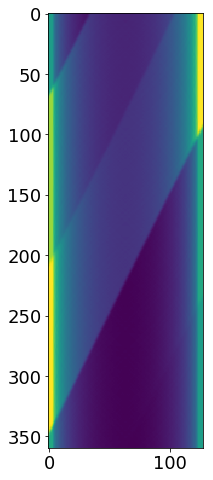

In [791]:

import spatialSpectralTools as st
import aiairecon

from scipy import signal
from scipy import io
from scipy import interpolate
import numpy as np
from matplotlib import pyplot as plt

from scipy import stats

from aiairecon_cudatools import fbp

import CudaTools

import importlib

importlib.reload(st)

# read the relevant attenuations
# spectra will be (141 x 2) 
#    first column is energy in keV
#    second column is attenuation coefficient in mm^2/g

water = st.rw.load_attenuations('water_atten.txt')
iodine = st.rw.load_attenuations('iodine_atten.txt')
gold = st.rw.load_attenuations('gold_atten.txt')
gadolinium = st.rw.load_attenuations('gadolinium.txt')
lutetium = st.rw.load_attenuations('lutetium_atten.txt')
erbium = st.rw.load_attenuations('erbium_atten.txt')
lead = st.rw.load_attenuations('lead_atten.txt')
aluminium = st.rw.load_attenuations('aluminium_atten.txt')
copper = st.rw.load_attenuations('copper_atten.txt')
tungsten = st.rw.load_attenuations('tungsten_atten.txt')

# also load CsI for detector properties
CsI = st.rw.load_attenuations('CsI_atten.txt')


# load the source spectrum 
# spectra will be (141 x 2) 
#    first column is energy in keV
#    second column is proportional to intensity

s = st.rw.load_spectrum('100kvp_spectrum.txt')









def load_source_spectrum(kev):

        kev_low = np.floor(kev)
        kev_high = np.ceil(kev)

        weight_bias = 0.001
        weight_low = 1.0/(weight_bias + kev - kev_low)
        weight_high = 1.0/(weight_bias + kev - kev_high)

        s_low = st.rw.load_spectrum('source_spectra/spectra_'  + str(np.int32(kev_low)) + '.txt')
        s_high = st.rw.load_spectrum('source_spectra/spectra_'  + str(np.int32(kev_high)) + '.txt')

        s = (weight_low*s_low + weight_high*s_high)/(weight_low + weight_high)

        return s




def compute_filter_spectra(     kev,
                                thk_Al,
                                thk_Cu,
                                thk_W,
                                thk_Pb,
                                thk_Au,
                                thk_Lu,
                                thk_Er,
                                thk_CsI):


        s = load_source_spectrum(kev)

        # filter material densities

        rho_Pb     = 11.34 / 1000 # g/mm^3
        rho_Au     = 19.3  / 1000 # g/mm^3
        rho_Lu     = 9.841 / 1000 # g/mm^3
        rho_Er     = 9.066 / 1000 # g/mm^3


        rho_Al     = 2.7 / 1000 # g/mm^3
        rho_Cu     = 8.96 / 1000 # g/mm^3
        rho_W     = 19.3 / 1000 # g/mm^3

        # photon energy
        kvps = s[:,0]

        # probability of interaction with detector
        rho_CsI = 4.51  / 1000 # g/mm^3
        P_interaction  = (1-np.exp(-thk_CsI*rho_CsI*CsI[:,1]))

        # final sensitivity spectra for each material
        #     for each photon energy take the product of:
        #         photon energy (signal is proportional to xray kev)
        #         probability of interaction with detector (which depends on CsI spectrum)
        #         source spectrum (how many xray photons of each energy were fired)
        #         the attenuation due to the given filter (following Beer-Lambert law)

        s_source = kvps * P_interaction * s[:,1]

        maxRef = np.max(s_source)

        s_source = s_source * np.exp(-thk_Al*rho_Al*aluminium[:,1])
        s_source = s_source * np.exp(-thk_Cu*rho_Cu*copper[:,1])
        s_source = s_source * np.exp(-thk_W*rho_W*tungsten[:,1])


        idxBad = (s_source < 0.0) | np.isnan(s_source) | np.isinf(s_source) | (s_source > 100.0*maxRef)
        if np.any(idxBad):
                s_source = kvps*P_interaction * s[:,1]


        s_Pb     = s_source * np.exp(-thk_Pb*rho_Pb*lead[:,1])
        s_Au     = s_source * np.exp(-thk_Au*rho_Au*gold[:,1])
        s_Lu     = s_source * np.exp(-thk_Lu*rho_Lu*lutetium[:,1])
        s_Er     = s_source * np.exp(-thk_Er*rho_Er*erbium[:,1])


        return (s_source, s_Pb, s_Au, s_Lu, s_Er)



kev     = 99.608
thk_Al  = 0.3447
thk_Cu  = 0.7770
thk_W   = -0.0151
thk_Pb  = 0.2171
thk_Au  = 0.0865
thk_Lu  = 0.1077
thk_Er  = 0.1500
thk_CsI = 0.7100

(s_source, s_Pb, s_Au, s_Lu, s_Er) = compute_filter_spectra(    kev,
                                                                thk_Al,
                                                                thk_Cu,
                                                                thk_W,
                                                                thk_Pb,
                                                                thk_Au,
                                                                thk_Lu,
                                                                thk_Er,
                                                                thk_CsI)



s_lead = s_Pb
s_gold = s_Au
s_lutetium = s_Lu
s_erbium = s_Er




# here are some parameters from a benchtop CT acquisition
SDD = 1105.003
SAD = 829.403
nProj = 360
nPixel = 128
pixelSpacing = 0.556
proj_offset_x = 0.0
proj_offset_y = 0.0
# proj_offset_y must be zero for a 2D recon. 
#  (this needs another look)
proj_offset_y = 0.000

# more parameters for the recon
nX = 128
nZ = 128
voxelSpacing = 0.5



nVoxels = nX

nEnergy = 141
nMaterials = 4

betaWater = 1e0
betaIodine = 8e11
betaGadolinium = 14e11
betaGold = 19e11

#betaWater = 1e12
#betaIodine = 1e12
#betaGadolinium = 1e12

betas = (betaWater, betaIodine, betaGadolinium, betaGold)

photon_counts = 1e7
gain = photon_counts/np.sum(s_lead)

nFilter = 4
SFD = 380.0

FilterWidthMm = 16.0*0.556/(SDD/SFD)
FilterWidthPixels = FilterWidthMm*(SDD/SFD)/pixelSpacing

# FilterWidthPixels = 2.0*filter_widths[iFilterWidth]

FilterWidthPixels = 70.0

FocalSpotWidthMm = 0.5
FocalSpotWidthPixels = FocalSpotWidthMm*(SDD/SFD)/pixelSpacing

RPM = 60.0
RPS = RPM/60.0

FilterSpeedMmPerS = 100.0
FilterSpeedPixelsPerView = FilterSpeedMmPerS * (1/RPS) * (1/nProj) * (1/pixelSpacing)



#FilterSpeedPixelsPerView = 40.0*FilterWidthPixels*nFilter/nProj



R, _, C = np.ogrid[:nX, :1, :nZ]

xgrid = C*voxelSpacing
zgrid = R*voxelSpacing

xgrid = xgrid - np.mean(xgrid)
zgrid = zgrid - np.mean(zgrid)

x = np.zeros( (nMaterials , nX , 1 , nZ) )
x[0, (xgrid - 0.0) ** 2.0  +  (zgrid - 0.0) ** 2.0  <= 25.0 ** 2.0] = 1000e-6



theta = np.arange(0.0, 2.0*np.pi, 2.0*np.pi/12.0)

xcenter = 20.0*np.cos(theta)
zcenter = 20.0*np.sin(theta)

concentration_iodine     = [ 1.6e-6,   0.8e-6,  0.4e-6, 0.2e-6,  0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0    ] 
concentration_gadolinium = [ 0.0,      0.0,     0.0,    0.0,     1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6,  0.0,     0.0,     0.0,     0.0    ] 
concentration_gold       = [ 0.0,      0.0,     0.0,    0.0,     0.0,     0.0,     0.0,     0.0,     1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6 ] 

for iTheta in np.arange(0, len(theta)):
    x[1, (xgrid - xcenter[iTheta]) ** 2.0  +  (zgrid - zcenter[iTheta]) ** 2.0  <= 3.0 ** 2.0] = concentration_iodine[iTheta]	
    x[2, (xgrid - xcenter[iTheta]) ** 2.0  +  (zgrid - zcenter[iTheta]) ** 2.0  <= 3.0 ** 2.0] = concentration_gadolinium[iTheta]	
    x[3, (xgrid - xcenter[iTheta]) ** 2.0  +  (zgrid - zcenter[iTheta]) ** 2.0  <= 3.0 ** 2.0] = concentration_gold[iTheta]	





theta = np.arange(0.0, 2.0*np.pi, 2.0*np.pi/12.0)

xcenter = 13.0*np.cos(theta)
zcenter = 13.0*np.sin(theta)

concentration_iodine     = [ 0.8e-6,  1.6e-6,  1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6,  0.0,     0.0,     0.0,     0.0,     0.2e-6,  0.4e-6  ] 
concentration_gadolinium = [ 0.0,     0.0,     0.2e-6,  0.4e-6,  0.8e-6,  1.6e-6,  1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6,  0.0,     0.0     ] 
concentration_gold       = [ 0.4e-6,  0.2e-6,  0.0,     0.0,     0.0,     0.0,     0.2e-6,  0.4e-6,  0.8e-6,  1.6e-6,  1.6e-6,  0.8e-6  ] 

for iTheta in np.arange(0, len(theta)):
    x[1, (xgrid - xcenter[iTheta]) ** 2.0  +  (zgrid - zcenter[iTheta]) ** 2.0  <= 3.0 ** 2.0] = concentration_iodine[iTheta]	
    x[2, (xgrid - xcenter[iTheta]) ** 2.0  +  (zgrid - zcenter[iTheta]) ** 2.0  <= 3.0 ** 2.0] = concentration_gadolinium[iTheta]	
    x[3, (xgrid - xcenter[iTheta]) ** 2.0  +  (zgrid - zcenter[iTheta]) ** 2.0  <= 3.0 ** 2.0] = concentration_gold[iTheta]	





print('making A...')

materialSpectra = np.stack( (water[:,1], iodine[:,1], gadolinium[:,1], gold[:,1]),axis=1 ) 

A = st.mt.make_spectral_A_matrix(SDD,
          SAD,
          nProj,
          proj_offset_x,
          proj_offset_y,
          nPixel,
          nX,
          nZ, 
          pixelSpacing, 
          voxelSpacing,
          materialSpectra)



print('making spectral_weights...')

filterSpectra = np.stack( (s_lead, s_gold, s_lutetium, s_erbium) , axis=1)
filterSpectra = np.swapaxes(filterSpectra, 0, 1)





spectral_weights = st.mt.make_spectral_weights_switching(nProj,
                             nPixel,
                             nFilter)


spectral_weights = st.mt.make_spectral_weights(nProj,
                           nPixel,
                           nFilter,
                           FilterWidthPixels,
                           FocalSpotWidthPixels,
                           FilterSpeedPixelsPerView)


print('making spectral_scale...')

spectral_scale = st.mt.make_spectral_scale(spectral_weights,
                       filterSpectra)


print('making B...')
B = st.mt.make_spectral_B_matrix(spectral_scale, 
          gain)


print('making R...')
R = st.rn.make_quadratic_penalty(betas,
               [nMaterials, nZ, 1, nX])



print('making y...')

#ystack = np.stack( (y_phantom_Pb, y_phantom_Au, y_phantom_Lu, y_phantom_Er), axis=3)

#ystack = np.transpose(ystack, (3, 0, 1, 2))

y = B.dot(np.exp(-A.dot(x)))
y = np.random.poisson(lam=y, size=y.shape).astype(np.float32)


#y = st.mt.make_stitched_data(spectral_weights,
#                        ystack)







#x = np.zeros([nMaterials,nZ,1,nX])

#x[0,25:125,0,25:125] = 1000e-6
#x[1,50:75,0,50:75] = 20e-6
#x[2,85:110,0,85:110] = 20e-6

#y = B.dot(np.exp(-A.dot(x)))



print('making x0...')

# seed image: 
#   ground truth for water

x0 = np.zeros([nMaterials,nZ,1,nX])

x0[0,:,:,:] = x[0,:,:,:]
#x0[1,:,:,:] = x[0,:,:,:]/100.0
#x0[2,:,:,:] = x[0,:,:,:]/100.0
#x0[3,:,:,:] = x[0,:,:,:]/100.0

#x[0,25:125,0,25:125] = 1000e-6
#x[1,50:75,0,50:75] = 20e-6
#x[2,85:110,0,85:110] = 20e-6

#x0 = np.zeros([nMaterials,nZ,1,nX])

#x0[0,:,:,:] = x[0,:,:,:]
#x0[1,:,:,:] = (20/1000)*x[0,:,:,:]
#x0[2,:,:,:] = (20/1000)*x[0,:,:,:]



y_hat = B.dot(np.exp(-A.dot(x0)))

plt.figure(figsize=(8,8))

plt.imshow(np.squeeze(y_hat))


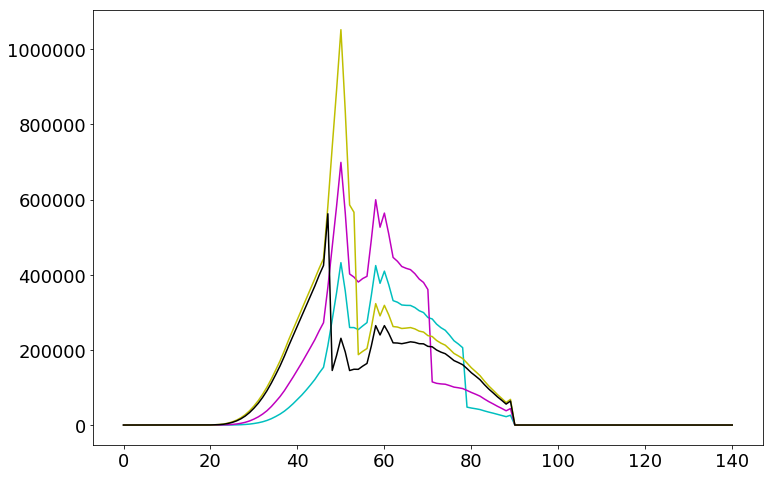

In [792]:
plt.figure(figsize=(12,8))
plt.plot(s_lead,color='c')
plt.plot(s_gold,color='m')
plt.plot(s_lutetium,color='y')
plt.plot(s_erbium,color='k')

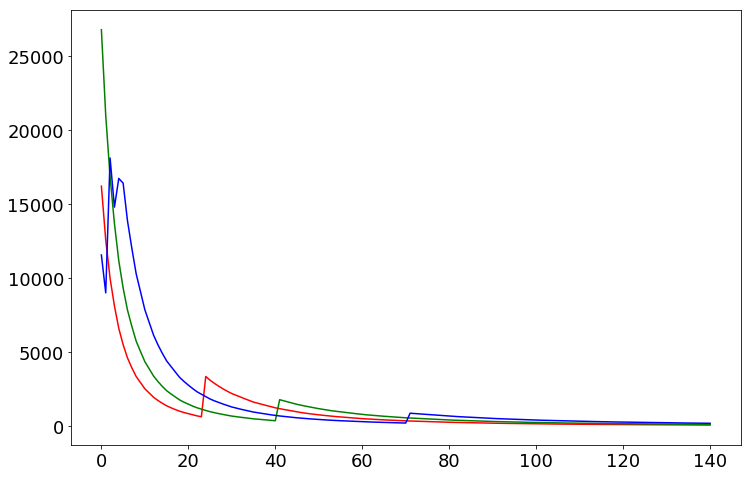

In [793]:
plt.figure(figsize=(12,8))
plt.plot(iodine[:,1],color='r')
plt.plot(gadolinium[:,1],color='g')
plt.plot(gold[:,1],color='b')


In [794]:

def RYB_2_RGB(r,y,b):
    
    
    redAxis = np.linspace(0.0, 1.0, 2)
    greenAxis = np.linspace(0.0, 1.0, 2)
    blueAxis = np.linspace(0.0, 1.0, 2)
    
    dataRed = np.zeros([2,2,2])
    dataGreen = np.zeros([2,2,2])
    dataBlue = np.zeros([2,2,2])
    
    dataRed[0,0,0] = 1.000  # white
    dataRed[0,0,1] = 0.163  # blue
    dataRed[0,1,0] = 0.900  # yellow
    dataRed[0,1,1] = 0.000  # green
    dataRed[1,0,0] = 1.000  # red
    dataRed[1,0,1] = 0.500  # violet
    dataRed[1,1,0] = 1.000  # orange
    dataRed[1,1,1] = 0.200  # black
    
    dataGreen[0,0,0] = 1.000  # white
    dataGreen[0,0,1] = 0.373  # blue
    dataGreen[0,1,0] = 0.800  # yellow
    dataGreen[0,1,1] = 0.660  # green
    dataGreen[1,0,0] = 0.000  # red
    dataGreen[1,0,1] = 0.000  # violet
    dataGreen[1,1,0] = 0.500  # orange
    dataGreen[1,1,1] = 0.095  # black
    
    dataBlue[0,0,0] = 1.000  # white
    dataBlue[0,0,1] = 0.600  # blue
    dataBlue[0,1,0] = 0.000  # yellow
    dataBlue[0,1,1] = 0.200  # green
    dataBlue[1,0,0] = 0.000  # red
    dataBlue[1,0,1] = 0.500  # violet
    dataBlue[1,1,0] = 0.000  # orange
    dataBlue[1,1,1] = 0.000  # black
    
    
    
    interpRed   = interpolate.RegularGridInterpolator((redAxis, greenAxis, blueAxis), dataRed)
    interpGreen = interpolate.RegularGridInterpolator((redAxis, greenAxis, blueAxis), dataGreen)
    interpBlue  = interpolate.RegularGridInterpolator((redAxis, greenAxis, blueAxis), dataBlue)

    
    r = np.array(r).transpose()
    y = np.array(y).transpose()
    b = np.array(b).transpose()
    
    
    R = interpRed(np.array([r,y,b]).transpose())
    G = interpGreen(np.array([r,y,b]).transpose())
    B = interpBlue(np.array([r,y,b]).transpose())
    
    
    return (R,G,B)



(R,G,B) = RYB_2_RGB(1.0,1.0,1.0)




def RYB_2_RGB_img(imgRYB):
    
    imgRGB = np.zeros_like(imgRYB)
        
    (R,G,B) = RYB_2_RGB(imgRYB[:,:,0].flatten(), imgRYB[:,:,1].flatten(), imgRYB[:,:,2].flatten())
    
    imgRGB[:,:,0] = np.reshape(R,imgRGB[:,:,0].shape)
    imgRGB[:,:,1] = np.reshape(G,imgRGB[:,:,1].shape)
    imgRGB[:,:,2] = np.reshape(B,imgRGB[:,:,2].shape)
    
    
#     for iX in np.arange(0, imgRYB.shape[0]):
#         for iY in np.arange(0, imgRYB.shape[1]):
    
#             r = imgRYB[iX,iY,0]
#             y = imgRYB[iX,iY,1]
#             b = imgRYB[iX,iY,2]
    
#             (R,G,B) = RYB_2_RGB(r,y,b)
        
#             imgRGB[iX,iY,0] = R
#             imgRGB[iX,iY,1] = G
#             imgRGB[iX,iY,2] = B
    
    return imgRGB






(R,G,B) = RYB_2_RGB([0,1],[0,1],[0,1])

print(R)
print(G)
print(B)



[1.  0.2]
[1.    0.095]
[1. 0.]


In [795]:
def CMYK_y(spectral_weights):
    
    spectral_weights = np.squeeze(spectral_weights)
    
    y_RGB = np.zeros([spectral_weights.shape[1], spectral_weights.shape[2], 3])
            
    maskRed = np.zeros_like(y_RGB)
    maskRed[:,:,0] = 1.0

    maskGreen = np.zeros_like(y_RGB)
    maskGreen[:,:,1] = 1.0

    maskBlue = np.zeros_like(y_RGB)
    maskBlue[:,:,2] = 1.0
    
    
    maskWhite = maskRed + maskGreen + maskBlue
    maskBlack = 0*maskWhite
    
    
    maskYellow   = maskRed   + maskGreen
    maskMagenta  = maskRed   + maskBlue
    maskCyan     = maskGreen + maskBlue    
    
    print(np.stack( (spectral_weights[0,:,:],spectral_weights[0,:,:],spectral_weights[0,:,:]),2).shape)
    
    y_R = np.stack( (spectral_weights[0,:,:],spectral_weights[0,:,:],spectral_weights[0,:,:]),2)*maskRed
    y_G = np.stack( (spectral_weights[1,:,:],spectral_weights[1,:,:],spectral_weights[1,:,:]),2)*maskGreen
    y_B = np.stack( (spectral_weights[2,:,:],spectral_weights[2,:,:],spectral_weights[2,:,:]),2)*maskBlue
    y_W = np.stack( (spectral_weights[3,:,:],spectral_weights[3,:,:],spectral_weights[3,:,:]),2)*maskBlack
    
    bias = 0.001
    y_R = y_R/(np.max(y_R) + bias)
    y_G = y_G/(np.max(y_G) + bias)
    y_B = y_B/(np.max(y_B) + bias)
#     y_W = y_W/np.max(y_W)
    
    y_RGB = y_R + y_G + y_B + y_W
    
    y_RGB[y_RGB > 1.0] = 1.0
    y_RGB[y_RGB < 0.0] = 0.0
    
    
    
    y_RGB = RYB_2_RGB_img(1.0 - y_RGB)
    
    
    plt.imshow(y_RGB)
    
    plt.rcParams.update({'font.size': 18})

    
    xtic = np.arange(0,128,32)
    xticlabel = np.arange(-32,33,16)
    xtic = (xticlabel + 64.5*0.556)/0.556
    
    
    plt.xticks(xtic, xticlabel)
#     plt.xticks(xtic)
    plt.xlabel('Projection Position (mm)')
    plt.ylabel('View Angle (deg)')
    
    
    

(4, 360, 1, 128)
(360, 128, 3)


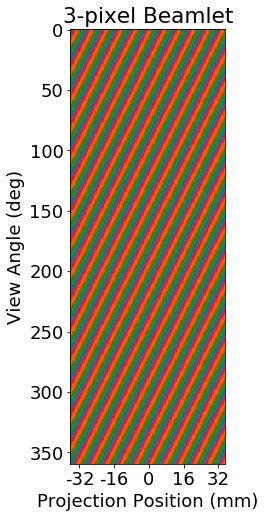

In [802]:
FilterWidthPixels = 3.0
FocalSpotWidthPixels = 5.2

spectral_weights = st.mt.make_spectral_weights(nProj,
                           nPixel,
                           nFilter,
                           FilterWidthPixels,
                           FocalSpotWidthPixels,
                           FilterSpeedPixelsPerView)

spectral_scale = st.mt.make_spectral_scale(spectral_weights,
                       filterSpectra)

B = st.mt.make_spectral_B_matrix(spectral_scale, 
          gain)

y_hat = B.dot(np.exp(-A.dot(x0*0.0)))

plt.figure(figsize=(8,8))

print(spectral_weights.shape)

plt.imshow(np.squeeze(y_hat))

CMYK_y(spectral_weights)
plt.title('3-pixel Beamlet')

plt.savefig('figures/CMYK_xi3.png',format='png')

(4, 360, 1, 128)
(360, 128, 3)


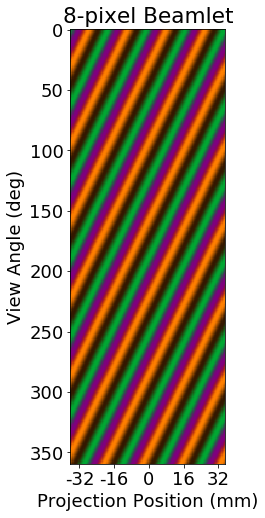

In [803]:
FilterWidthPixels = 8.0

spectral_weights = st.mt.make_spectral_weights(nProj,
                           nPixel,
                           nFilter,
                           FilterWidthPixels,
                           FocalSpotWidthPixels,
                           FilterSpeedPixelsPerView)

spectral_scale = st.mt.make_spectral_scale(spectral_weights,
                       filterSpectra)

B = st.mt.make_spectral_B_matrix(spectral_scale, 
          gain)

y_hat = B.dot(np.exp(-A.dot(x0*0.0)))

plt.figure(figsize=(8,8))

print(spectral_weights.shape)

CMYK_y(spectral_weights)
plt.title('8-pixel Beamlet')

plt.savefig('figures/CMYK_xi8.png',format='png')

(4, 360, 1, 128)
(360, 128, 3)


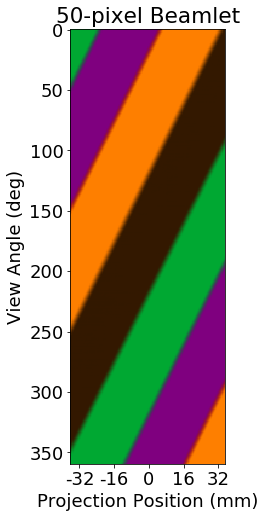

In [804]:
FilterWidthPixels = 50.0

spectral_weights = st.mt.make_spectral_weights(nProj,
                           nPixel,
                           nFilter,
                           FilterWidthPixels,
                           FocalSpotWidthPixels,
                           FilterSpeedPixelsPerView)

spectral_scale = st.mt.make_spectral_scale(spectral_weights,
                       filterSpectra)

B = st.mt.make_spectral_B_matrix(spectral_scale, 
          gain)

y_hat = B.dot(np.exp(-A.dot(x0*0.0)))

plt.figure(figsize=(8,8))

print(spectral_weights.shape)


plt.imshow(np.squeeze(spectral_weights[0,:,:,:]))
CMYK_y(spectral_weights)
plt.title('50-pixel Beamlet')

plt.savefig('figures/CMYK_xi50.png',format='png')


In [629]:
data = io.loadmat('data2/xi5.mat')
xi = data['xi'] 

print(xi.shape)

(4, 128, 1, 128)


DEBUG
128
128
(4, 128, 1, 128)
(1, 1, 128)


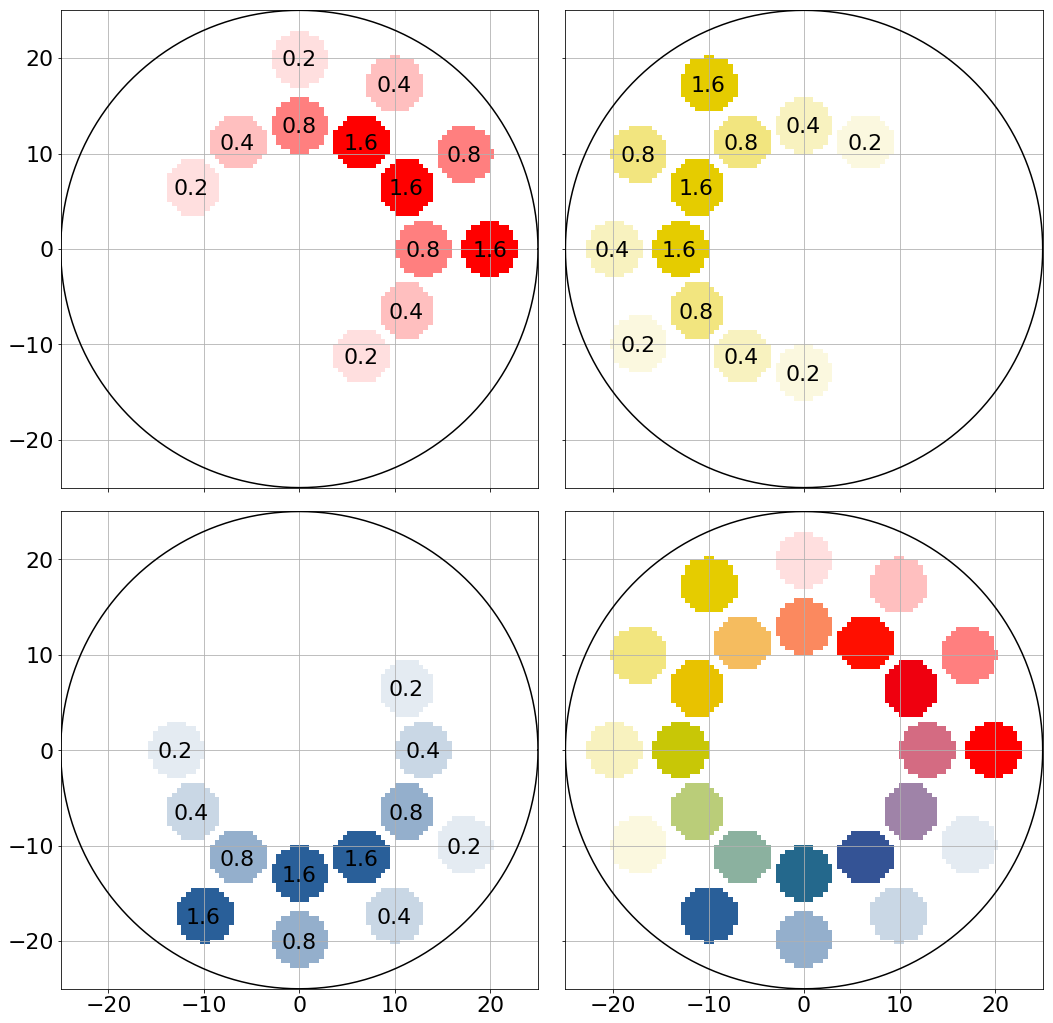

In [726]:


def RGB_x(xi):
    
    
    nX = xi.shape[1]
    nZ = xi.shape[3]
    
    R, _, C = np.ogrid[0:nX, :1, 0:nZ]
    
    print('DEBUG')
    print(nX)
    print(nZ)
    print(xi.shape)
    print(C.shape)
    
    xgrid = C*voxelSpacing
    zgrid = R*voxelSpacing
    
    xgrid = xgrid - np.mean(xgrid)
    zgrid = zgrid - np.mean(zgrid)
    
#     xi[:, (xgrid - 0.0) ** 2.0  +  (zgrid - 0.0) ** 2.0  > 25.0 ** 2.0] = 0.0    

    xi_RGB = np.transpose(xi[1:,:,0,:],(1,2,0))

    xi_RGB = xi_RGB/1.6e-6
    
    xi_RGB[xi_RGB>1.0] = 1.0


    maskRed = np.zeros_like(xi_RGB)
    maskRed[:,:,0] = 1.0

    maskGreen = np.zeros_like(xi_RGB)
    maskGreen[:,:,1] = 1.0

    maskBlue = np.zeros_like(xi_RGB)
    maskBlue[:,:,2] = 1.0

    maskYellow   = maskRed   + maskGreen
    maskMagenta  = maskRed   + maskBlue
    maskCyan     = maskGreen + maskBlue


    xRed   = 1.0 - np.stack((xi_RGB[:,:,0], xi_RGB[:,:,0], xi_RGB[:,:,0]),2)*maskCyan
    xGreen = 1.0 - np.stack((xi_RGB[:,:,1], xi_RGB[:,:,1], xi_RGB[:,:,1]),2)*maskMagenta
    xBlue  = 1.0 - np.stack((xi_RGB[:,:,2], xi_RGB[:,:,2], xi_RGB[:,:,2]),2)*maskYellow

    xRed   = np.stack((xi_RGB[:,:,0], xi_RGB[:,:,0], xi_RGB[:,:,0]),2)*maskRed
    xGreen = np.stack((xi_RGB[:,:,1], xi_RGB[:,:,1], xi_RGB[:,:,1]),2)*maskGreen
    xBlue  = np.stack((xi_RGB[:,:,2], xi_RGB[:,:,2], xi_RGB[:,:,2]),2)*maskBlue

    offset = 0.2    
    
    font = {'color':  'black',
        }


    
    theta1 = np.arange(0.0, 2.0*np.pi, 2.0*np.pi/12.0)

    xcenter1 = 20.0*np.cos(theta1)
    zcenter1 = 20.0*np.sin(theta1)

    concentration_iodine1     = [ 1.6e-6,   0.8e-6,  0.4e-6, 0.2e-6,  0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0    ]
    concentration_gadolinium1 = [ 0.0,      0.0,     0.0,    0.0,     1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6,  0.0,     0.0,     0.0,     0.0    ]
    concentration_gold1       = [ 0.0,      0.0,     0.0,    0.0,     0.0,     0.0,     0.0,     0.0,     1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6 ]

    
    theta2 = np.arange(0.0, 2.0*np.pi, 2.0*np.pi/12.0)

    xcenter2 = 13.0*np.cos(theta2)
    zcenter2 = 13.0*np.sin(theta2)

    concentration_iodine2     = [ 0.8e-6,  1.6e-6,  1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6,  0.0,     0.0,     0.0,     0.0,     0.2e-6,  0.4e-6  ]
    concentration_gadolinium2 = [ 0.0,     0.0,     0.2e-6,  0.4e-6,  0.8e-6,  1.6e-6,  1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6,  0.0,     0.0     ]
    concentration_gold2       = [ 0.4e-6,  0.2e-6,  0.0,     0.0,     0.0,     0.0,     0.2e-6,  0.4e-6,  0.8e-6,  1.6e-6,  1.6e-6,  0.8e-6  ]


    ext = (np.min(xgrid), np.max(xgrid), np.max(zgrid), np.min(zgrid))
    
    

    plt.rcParams.update({'font.size': 22})

    # f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(18,18))
    # f.suptitle('Sharing x per column, y per row', fontsize=24)


    fig = plt.figure(figsize=(18,18))
    ax = [fig.add_subplot(2,2,i+1) for i in range(4)]

    
    
    
    
    
    xRed = RYB_2_RGB_img(xRed)
    xGreen = RYB_2_RGB_img(xGreen)
    xBlue = RYB_2_RGB_img(xBlue)
    xi_RGB = RYB_2_RGB_img(xi_RGB)
    
    
    
    
    
        
    
#     xshift = -2.3
#     zshift = 1.0
    
    xshift = -1.9
    zshift = -0.8
    
    for a in ax:
        a.set_aspect('equal')
        a.grid()

    ax[0].imshow(xRed,extent=ext)
    ax[0].set_xticklabels([])
    for iTheta in np.arange(0,len(theta1)):
        if(concentration_iodine1[iTheta] > 0.0):
            st = str(0.1*np.round(10*1e6*concentration_iodine1[iTheta]))
            ax[0].text(xshift + xcenter1[iTheta],zshift + zcenter1[iTheta],st, fontdict=font)
    for iTheta in np.arange(0,len(theta2)):
        if(concentration_iodine2[iTheta] > 0.0):
            st = str(0.1*np.round(10*1e6*concentration_iodine2[iTheta]))
            ax[0].text(xshift + xcenter2[iTheta],zshift + zcenter2[iTheta],st, fontdict=font)


    ax[1].imshow(xGreen,extent=ext)
    ax[1].set_xticklabels([])
    ax[1].set_yticklabels([])
    for iTheta in np.arange(0,len(theta1)):
        if(concentration_gadolinium1[iTheta] > 0.0):
            st = str(0.1*np.round(10*1e6*concentration_gadolinium1[iTheta]))
            ax[1].text(xshift + xcenter1[iTheta],zshift + zcenter1[iTheta],st, fontdict=font)
    for iTheta in np.arange(0,len(theta2)):
        if(concentration_gadolinium2[iTheta] > 0.0):
            st = str(0.1*np.round(10*1e6*concentration_gadolinium2[iTheta]))
            ax[1].text(xshift + xcenter2[iTheta],zshift + zcenter2[iTheta],st, fontdict=font)

            
    ax[2].imshow(xBlue,extent=ext)
    for iTheta in np.arange(0,len(theta1)):
        if(concentration_gold1[iTheta] > 0.0):
            st = str(0.1*np.round(10*1e6*concentration_gold1[iTheta]))
            ax[2].text(xshift + xcenter1[iTheta],zshift + zcenter1[iTheta],st, fontdict=font)
    for iTheta in np.arange(0,len(theta2)):
        if(concentration_gold2[iTheta] > 0.0):
            st = str(0.1*np.round(10*1e6*concentration_gold2[iTheta]))
            ax[2].text(xshift + xcenter2[iTheta],zshift + zcenter2[iTheta],st, fontdict=font)

    ax[3].imshow(xi_RGB,extent=ext)
    ax[3].set_yticklabels([])
    
    
    
    phi = np.linspace(0,2*np.pi,361)
    xx = 25.0*np.cos(phi)
    yy = 25.0*np.sin(phi)
    
    for a in ax:
        a.set_xlim(-25,25)
        a.set_ylim(-25,25)
        a.plot(xx,yy,'-k')

    plt.subplots_adjust(wspace=0.01, hspace=0.05)


RGB_x(x)




(128, 1, 128)
(11, 1, 11)


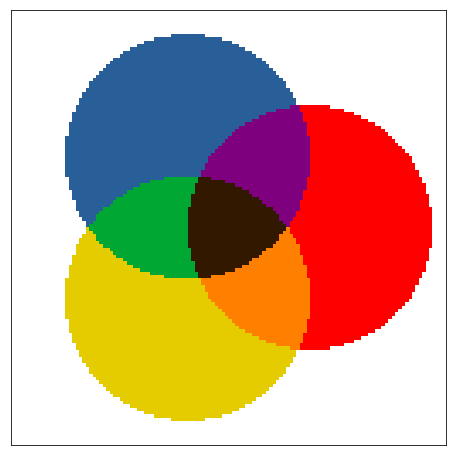

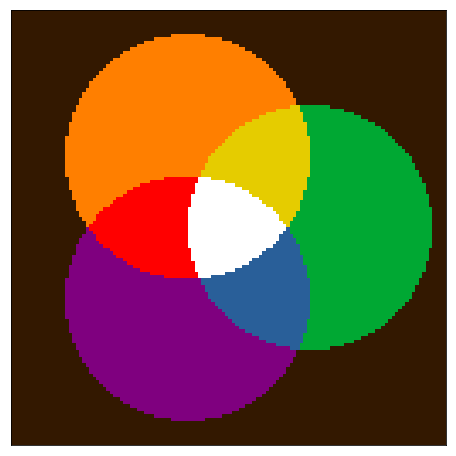

In [631]:
R, _, C = np.ogrid[:nX, :1, :nZ]

xgrid = C*voxelSpacing
zgrid = R*voxelSpacing

xgrid = xgrid - np.mean(xgrid)
zgrid = zgrid - np.mean(zgrid)

theta = np.linspace(0, 2*np.pi,4)
theta = theta[0:3]

theta = [0, 2*np.pi/3,  4*np.pi/3]


center_radius = 12.0

xcenter = center_radius*np.cos(theta)
zcenter = center_radius*np.sin(theta)

venn_radius = 18.0

xtmp = np.zeros_like(x0)
xtmp[1, (xgrid - xcenter[0]) ** 2.0  +  (zgrid - zcenter[0]) ** 2.0  < venn_radius ** 2.0] = 1.6e-6
xtmp[2, (xgrid - xcenter[1]) ** 2.0  +  (zgrid - zcenter[1]) ** 2.0  < venn_radius ** 2.0] = 1.6e-6
xtmp[3, (xgrid - xcenter[2]) ** 2.0  +  (zgrid - zcenter[2]) ** 2.0  < venn_radius ** 2.0] = 1.6e-6


ker = np.ones( [11,1,11] )
ker = ker/np.sum(ker)

print(xtmp[0,:,:].shape)
print(ker.shape)

# xtmp[0,:,:] = signal.convolve(xtmp[0,:,:],ker, 'same' )
# xtmp[1,:,:] = signal.convolve(xtmp[1,:,:],ker, 'same' )
# xtmp[2,:,:] = signal.convolve(xtmp[2,:,:],ker, 'same' )



xtmp_RGB = np.transpose(xtmp[1:,:,0,:],(1,2,0))
xtmp_RGB = xtmp_RGB/1.6e-6
xtmp_RGB[xi_RGB>1.0] = 1.0
xtmp_RGB[xi_RGB<0.0] = 0.0

xtmp_RGB = RYB_2_RGB_img(xtmp_RGB)

plt.figure(figsize=(8,8))
plt.imshow(xtmp_RGB)
plt.xticks([])
plt.yticks([])

plt.savefig('figures/colorMixingSubtractive.png', format='png')





xtmp = np.zeros_like(x0)
xtmp[1, (xgrid - xcenter[0]) ** 2.0  +  (zgrid - zcenter[0]) ** 2.0  < venn_radius ** 2.0] = 1.6e-6
xtmp[2, (xgrid - xcenter[1]) ** 2.0  +  (zgrid - zcenter[1]) ** 2.0  < venn_radius ** 2.0] = 1.6e-6
xtmp[3, (xgrid - xcenter[2]) ** 2.0  +  (zgrid - zcenter[2]) ** 2.0  < venn_radius ** 2.0] = 1.6e-6

xtmp_RGB = np.transpose(xtmp[1:,:,0,:],(1,2,0))
xtmp_RGB = xtmp_RGB/1.6e-6
xtmp_RGB[xi_RGB>1.0] = 1.0
xtmp_RGB[xi_RGB<0.0] = 0.0

xtmp_RGB = RYB_2_RGB_img(1.0-xtmp_RGB)

plt.figure(figsize=(8,8))
plt.imshow(xtmp_RGB)
plt.xticks([])
plt.yticks([])

plt.savefig('figures/colorMixingAdditive.png', format='png')



In [744]:
def RMSE_ROI(xi):
    
    
    R, _, C = np.ogrid[:nX, :1, :nZ]
        
    xgrid = C*voxelSpacing
    zgrid = R*voxelSpacing

    xgrid = xgrid - np.mean(xgrid)
    zgrid = zgrid - np.mean(zgrid)
    
    xi[:, (xgrid - 0.0) ** 2.0  +  (zgrid - 0.0) ** 2.0  > 25.0 ** 2.0] = 0.0    

    
    font = {'color':  'white',
        }

    
    theta1 = np.arange(0.0, 2.0*np.pi, 2.0*np.pi/12.0)

    xcenter1 = 20.0*np.cos(theta1)
    zcenter1 = 20.0*np.sin(theta1)

    concentration_iodine1     = [ 1.6e-6,   0.8e-6,  0.4e-6, 0.2e-6,  0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0    ]
    concentration_gadolinium1 = [ 0.0,      0.0,     0.0,    0.0,     1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6,  0.0,     0.0,     0.0,     0.0    ]
    concentration_gold1       = [ 0.0,      0.0,     0.0,    0.0,     0.0,     0.0,     0.0,     0.0,     1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6 ]

    
    theta2 = np.arange(0.0, 2.0*np.pi, 2.0*np.pi/12.0)

    xcenter2 = 13.0*np.cos(theta2)
    zcenter2 = 13.0*np.sin(theta2)

    concentration_iodine2     = [ 0.8e-6,  1.6e-6,  1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6,  0.0,     0.0,     0.0,     0.0,     0.2e-6,  0.4e-6  ]
    concentration_gadolinium2 = [ 0.0,     0.0,     0.2e-6,  0.4e-6,  0.8e-6,  1.6e-6,  1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6,  0.0,     0.0     ]
    concentration_gold2       = [ 0.4e-6,  0.2e-6,  0.0,     0.0,     0.0,     0.0,     0.2e-6,  0.4e-6,  0.8e-6,  1.6e-6,  1.6e-6,  0.8e-6  ]

    
    concentration_iodine1 = np.array(concentration_iodine1)
    concentration_gadolinium1 = np.array(concentration_gadolinium1)
    concentration_gold1 = np.array(concentration_gold1)
    
    concentration_iodine2 = np.array(concentration_iodine2)
    concentration_gadolinium2 = np.array(concentration_gadolinium2)
    concentration_gold2 = np.array(concentration_gold2)
    
    concentration_iodine  = np.concatenate((concentration_iodine1, concentration_iodine2), axis=0)
    concentration_gadolinium  = np.concatenate((concentration_gadolinium1, concentration_gadolinium2), axis=0)
    concentration_gold  = np.concatenate((concentration_gold1, concentration_gold2), axis=0)
    
    concentration_iodine.shape = [1, len(concentration_iodine)]
    concentration_gadolinium.shape = [1, len(concentration_gadolinium)]
    concentration_gold.shape = [1, len(concentration_gold)]
    
    concentration_iodine  = np.concatenate((concentration_iodine, concentration_iodine,concentration_iodine), axis=0)
    concentration_gadolinium  = np.concatenate((concentration_gadolinium, concentration_gadolinium,concentration_gadolinium), axis=0)
    concentration_gold  = np.concatenate((concentration_gold, concentration_gold, concentration_gold), axis=0)
    
    RMSE = np.zeros_like(concentration_iodine)
        
    for iTheta in np.arange(0, len(theta1)):
        RMSE[0,iTheta] = np.mean(  (xi[1, (xgrid - xcenter1[iTheta]) ** 2.0  +  (zgrid - zcenter1[iTheta]) ** 2.0  <= 2.0 ** 2.0] - concentration_iodine1[iTheta]) ** 2.0)
        RMSE[1,iTheta] = np.mean(  (xi[2, (xgrid - xcenter1[iTheta]) ** 2.0  +  (zgrid - zcenter1[iTheta]) ** 2.0  <= 2.0 ** 2.0] - concentration_gadolinium1[iTheta]) ** 2.0)
        RMSE[2,iTheta] = np.mean(  (xi[3, (xgrid - xcenter1[iTheta]) ** 2.0  +  (zgrid - zcenter1[iTheta]) ** 2.0  <= 2.0 ** 2.0] - concentration_gold1[iTheta]) ** 2.0)

    for iTheta in np.arange(0, len(theta2)):
        RMSE[0,iTheta + len(theta1)] = np.mean(  (xi[1, (xgrid - xcenter2[iTheta]) ** 2.0  +  (zgrid - zcenter2[iTheta]) ** 2.0  <= 2.0 ** 2.0] - concentration_iodine1[iTheta]) ** 2.0)
        RMSE[1,iTheta + len(theta1)] = np.mean(  (xi[2, (xgrid - xcenter2[iTheta]) ** 2.0  +  (zgrid - zcenter2[iTheta]) ** 2.0  <= 2.0 ** 2.0] - concentration_gadolinium1[iTheta]) ** 2.0)
        RMSE[2,iTheta + len(theta1)] = np.mean(  (xi[3, (xgrid - xcenter2[iTheta]) ** 2.0  +  (zgrid - zcenter2[iTheta]) ** 2.0  <= 2.0 ** 2.0] - concentration_gold1[iTheta]) ** 2.0)
    
    RMSE = np.sqrt(RMSE)
    
    return (concentration_iodine, concentration_gadolinium, concentration_gold, RMSE)
        
        
(concentration_iodine, concentration_gadolinium, concentration_gold, RMSE) = RMSE_ROI(xi)

print('RMSE:')
print(RMSE)

RMSE:
[[3.78083188e-07 3.25959346e-07 2.62707431e-07 1.78351411e-07
  2.08572277e-07 1.76577779e-07 4.64216083e-08 9.32310765e-08
  1.98822929e-07 9.34761682e-08 7.83851965e-08 7.02625688e-08
  9.41095880e-07 4.96184370e-07 7.47840921e-07 3.77635341e-07
  1.73440991e-07 3.83291312e-07 1.94842043e-07 2.98824565e-07
  7.04092813e-08 1.67608526e-07 3.23941304e-07 2.80158875e-07]
 [7.52689299e-08 9.42194613e-08 2.67739431e-08 1.66250846e-08
  3.70516188e-07 2.73868879e-07 1.41060121e-07 1.83545780e-07
  1.38479131e-08 1.19021282e-08 9.37869565e-09 2.21635115e-08
  6.66801597e-08 7.92436871e-08 3.47519058e-07 3.79304295e-07
  8.87719071e-07 5.25554353e-07 9.46609473e-07 3.73667807e-07
  3.81699346e-07 1.14831743e-07 7.20611581e-08 3.63214273e-08]
 [2.16458220e-07 6.15309204e-08 8.67013528e-08 5.78698249e-08
  5.64837122e-08 6.78921460e-08 4.37630188e-08 8.07000294e-08
  4.55747657e-07 3.05831913e-07 2.52538089e-07 1.72844942e-07
  2.12815545e-07 4.06709458e-07 1.40345720e-07 9.92683630e-08


<Figure size 864x288 with 0 Axes>

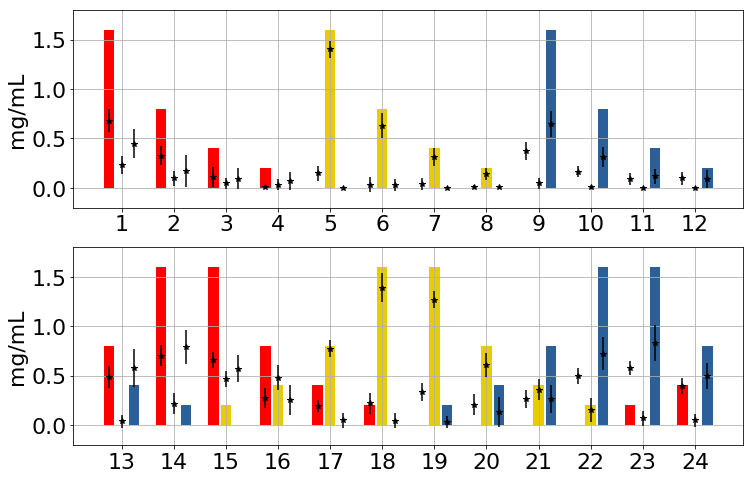

In [684]:
def bar_ROI(xi):
    
    
    R, _, C = np.ogrid[:nX, :1, :nZ]
        
    xgrid = C*voxelSpacing
    zgrid = R*voxelSpacing

    xgrid = xgrid - np.mean(xgrid)
    zgrid = zgrid - np.mean(zgrid)
    
    xi[:, (xgrid - 0.0) ** 2.0  +  (zgrid - 0.0) ** 2.0  > 25.0 ** 2.0] = 0.0    

    
    font = {'color':  'white',
        }

    
    theta1 = np.arange(0.0, 2.0*np.pi, 2.0*np.pi/12.0)

    xcenter1 = 20.0*np.cos(theta1)
    zcenter1 = 20.0*np.sin(theta1)

    concentration_iodine1     = [ 1.6e-6,   0.8e-6,  0.4e-6, 0.2e-6,  0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0    ]
    concentration_gadolinium1 = [ 0.0,      0.0,     0.0,    0.0,     1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6,  0.0,     0.0,     0.0,     0.0    ]
    concentration_gold1       = [ 0.0,      0.0,     0.0,    0.0,     0.0,     0.0,     0.0,     0.0,     1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6 ]

    
    theta2 = np.arange(0.0, 2.0*np.pi, 2.0*np.pi/12.0)

    xcenter2 = 13.0*np.cos(theta2)
    zcenter2 = 13.0*np.sin(theta2)

    concentration_iodine2     = [ 0.8e-6,  1.6e-6,  1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6,  0.0,     0.0,     0.0,     0.0,     0.2e-6,  0.4e-6  ]
    concentration_gadolinium2 = [ 0.0,     0.0,     0.2e-6,  0.4e-6,  0.8e-6,  1.6e-6,  1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6,  0.0,     0.0     ]
    concentration_gold2       = [ 0.4e-6,  0.2e-6,  0.0,     0.0,     0.0,     0.0,     0.2e-6,  0.4e-6,  0.8e-6,  1.6e-6,  1.6e-6,  0.8e-6  ]

    concentrations1 = np.zeros([3,len(theta1)])
    concentrations2 = np.zeros([3,len(theta2)])
    
    concentrations1[0,:] = concentration_iodine1
    concentrations1[1,:] = concentration_gadolinium1
    concentrations1[2,:] = concentration_gold1
    
    concentrations2[0,:] = concentration_iodine2
    concentrations2[1,:] = concentration_gadolinium2
    concentrations2[2,:] = concentration_gold2
    
    roi_means1 = np.zeros_like(concentrations1)
    roi_means2 = np.zeros_like(concentrations2)
    
    roi_vars1 = np.zeros_like(concentrations1)
    roi_vars2 = np.zeros_like(concentrations2)
    
    for iTheta in np.arange(0, len(theta1)):
        roi_means1[0,iTheta] = np.mean(xi[1, (xgrid - xcenter1[iTheta]) ** 2.0  +  (zgrid - zcenter1[iTheta]) ** 2.0  <= 2.0 ** 2.0]) 
        roi_means1[1,iTheta] = np.mean(xi[2, (xgrid - xcenter1[iTheta]) ** 2.0  +  (zgrid - zcenter1[iTheta]) ** 2.0  <= 2.0 ** 2.0])
        roi_means1[2,iTheta] = np.mean(xi[3, (xgrid - xcenter1[iTheta]) ** 2.0  +  (zgrid - zcenter1[iTheta]) ** 2.0  <= 2.0 ** 2.0])
        roi_vars1[0,iTheta] = np.var(xi[1, (xgrid - xcenter1[iTheta]) ** 2.0  +  (zgrid - zcenter1[iTheta]) ** 2.0  <= 2.0 ** 2.0]) 
        roi_vars1[1,iTheta] = np.var(xi[2, (xgrid - xcenter1[iTheta]) ** 2.0  +  (zgrid - zcenter1[iTheta]) ** 2.0  <= 2.0 ** 2.0])
        roi_vars1[2,iTheta] = np.var(xi[3, (xgrid - xcenter1[iTheta]) ** 2.0  +  (zgrid - zcenter1[iTheta]) ** 2.0  <= 2.0 ** 2.0]) 

    for iTheta in np.arange(0, len(theta2)):
        roi_means2[0,iTheta] = np.mean(xi[1, (xgrid - xcenter2[iTheta]) ** 2.0  +  (zgrid - zcenter2[iTheta]) ** 2.0  <= 2.0 ** 2.0]) 
        roi_means2[1,iTheta] = np.mean(xi[2, (xgrid - xcenter2[iTheta]) ** 2.0  +  (zgrid - zcenter2[iTheta]) ** 2.0  <= 2.0 ** 2.0])
        roi_means2[2,iTheta] = np.mean(xi[3, (xgrid - xcenter2[iTheta]) ** 2.0  +  (zgrid - zcenter2[iTheta]) ** 2.0  <= 2.0 ** 2.0])
        roi_vars2[0,iTheta] = np.var(xi[1, (xgrid - xcenter2[iTheta]) ** 2.0  +  (zgrid - zcenter2[iTheta]) ** 2.0  <= 2.0 ** 2.0]) 
        roi_vars2[1,iTheta] = np.var(xi[2, (xgrid - xcenter2[iTheta]) ** 2.0  +  (zgrid - zcenter2[iTheta]) ** 2.0  <= 2.0 ** 2.0])
        roi_vars2[2,iTheta] = np.var(xi[3, (xgrid - xcenter2[iTheta]) ** 2.0  +  (zgrid - zcenter2[iTheta]) ** 2.0  <= 2.0 ** 2.0]) 
        
    concentration_iodine1     = [ 1.6e-6,   0.8e-6,  0.4e-6, 0.2e-6,  0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0    ]
    concentration_gadolinium1 = [ 0.0,      0.0,     0.0,    0.0,     1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6,  0.0,     0.0,     0.0,     0.0    ]
    concentration_gold1       = [ 0.0,      0.0,     0.0,    0.0,     0.0,     0.0,     0.0,     0.0,     1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6 ]

    concentration_iodine2     = [ 0.8e-6,  1.6e-6,  1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6,  0.0,     0.0,     0.0,     0.0,     0.2e-6,  0.4e-6  ]
    concentration_gadolinium2 = [ 0.0,     0.0,     0.2e-6,  0.4e-6,  0.8e-6,  1.6e-6,  1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6,  0.0,     0.0     ]
    concentration_gold2       = [ 0.4e-6,  0.2e-6,  0.0,     0.0,     0.0,     0.0,     0.2e-6,  0.4e-6,  0.8e-6,  1.6e-6,  1.6e-6,  0.8e-6  ]

    concentrations_GT1 = np.zeros([3,len(theta1)])
    concentrations_GT2 = np.zeros([3,len(theta2)])
    
    concentrations_GT1[0,:] = concentration_iodine1
    concentrations_GT1[1,:] = concentration_gadolinium1
    concentrations_GT1[2,:] = concentration_gold1
    
    concentrations_GT2[0,:] = concentration_iodine2
    concentrations_GT2[1,:] = concentration_gadolinium2
    concentrations_GT2[2,:] = concentration_gold2
    
    
    
    plt.figure(figsize=(12,4))
    
    f, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
    
    ax1.bar(np.arange(1,13)-0.24,concentrations_GT1[0,:].transpose()*1e6,0.2,color=[1.0,0.0,0.0])
    ax1.bar(np.arange(1,13),concentrations_GT1[1,:].transpose()*1e6,0.2, color=[0.9,0.8,0.0])
    ax1.bar(np.arange(1,13)+0.24,concentrations_GT1[2,:].transpose()*1e6,0.2, color = [0.163,0.373,0.6])
    
    ax1.errorbar(np.arange(1,13)-0.24, roi_means1[0,:]*1e6, yerr=np.sqrt(roi_vars1[0,:]*1e6*1e6), fmt='*k')
    ax1.errorbar(np.arange(1,13)     , roi_means1[1,:]*1e6, yerr=np.sqrt(roi_vars1[1,:]*1e6*1e6), fmt='*k')
    ax1.errorbar(np.arange(1,13)+0.24, roi_means1[2,:]*1e6, yerr=np.sqrt(roi_vars1[2,:]*1e6*1e6), fmt='*k')
    
    ax1.grid()
    ax1.set_ylim([-0.2, 1.8])
    ax1.set_xticks(np.arange(1,13))
    ax1.set_ylabel('mg/mL')
    
    ax2.bar(np.arange(1,13)-0.24,concentrations_GT2[0,:].transpose()*1e6,0.2,color=[1.0,0.0,0.0])
    ax2.bar(np.arange(1,13),concentrations_GT2[1,:].transpose()*1e6,0.2, color=[0.9,0.8,0.0])
    ax2.bar(np.arange(1,13)+0.24,concentrations_GT2[2,:].transpose()*1e6,0.2, color = [0.163,0.373,0.6])
    
    ax2.errorbar(np.arange(1,13)-0.24, roi_means2[0,:]*1e6, yerr=np.sqrt(roi_vars2[0,:]*1e6*1e6), fmt='*k')
    ax2.errorbar(np.arange(1,13)     , roi_means2[1,:]*1e6, yerr=np.sqrt(roi_vars2[1,:]*1e6*1e6), fmt='*k')
    ax2.errorbar(np.arange(1,13)+0.24, roi_means2[2,:]*1e6, yerr=np.sqrt(roi_vars2[2,:]*1e6*1e6), fmt='*k')
    
    ax2.grid()
    ax2.set_ylim([-0.2, 1.8])
    ax2.set_xticks(np.arange(1,13))
    ax2.set_xticklabels(np.arange(13,25))
    ax2.set_ylabel('mg/mL')

bar_ROI(xi)



DEBUG
128
128
(4, 128, 1, 128)
(1, 1, 128)


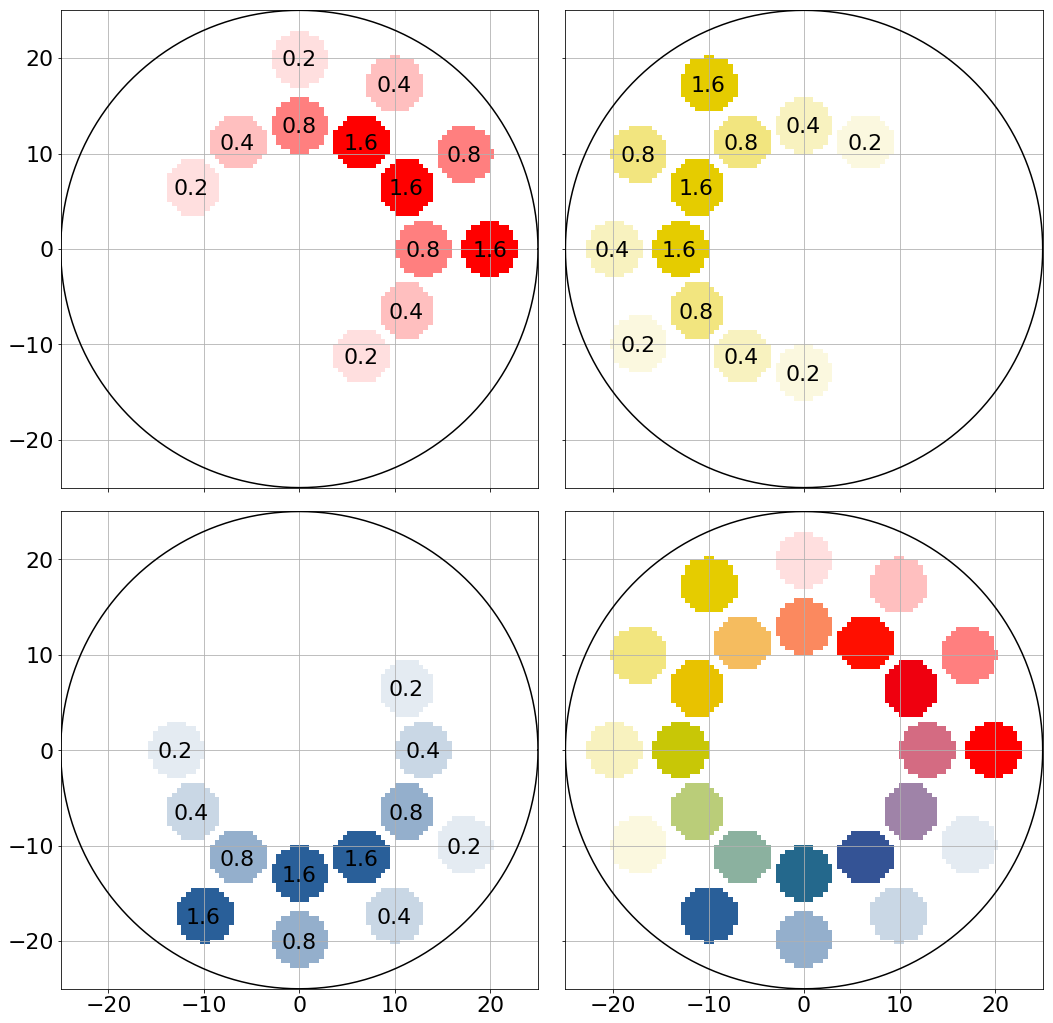

In [730]:
# here are some parameters from a benchtop CT acquisition
SDD = 1105.003
SAD = 829.403
nProj = 360
nPixel = 128
pixelSpacing = 0.556
proj_offset_x = 0.0
proj_offset_y = 0.0
# proj_offset_y must be zero for a 2D recon. 
#  (this needs another look)
proj_offset_y = 0.000

# more parameters for the recon
nX = 128
nZ = 128
voxelSpacing = 0.5



nVoxels = nX

nEnergy = 141
nMaterials = 4

betaWater = 1e0
betaIodine = 8e11
betaGadolinium = 14e11
betaGold = 19e11


betas = (betaWater, betaIodine, betaGadolinium, betaGold)

# photon_counts = 1e7
# gain = photon_counts/np.sum(s_lead)

nFilter = 4
SFD = 380.0

FilterWidthMm = 16.0*0.556/(SDD/SFD)
FilterWidthPixels = FilterWidthMm*(SDD/SFD)/pixelSpacing

# FilterWidthPixels = 1.0*filter_widths[iFilterWidth]

FocalSpotWidthMm = 2.0
FocalSpotWidthPixels = FocalSpotWidthMm*(SDD/SFD)/pixelSpacing

FilterSpeedPixelsPerView = 40.0*FilterWidthPixels*nFilter/nProj



R, _, C = np.ogrid[:nX, :1, :nZ]

xgrid = C*voxelSpacing
zgrid = R*voxelSpacing

xgrid = xgrid - np.mean(xgrid)
zgrid = zgrid - np.mean(zgrid)

x = np.zeros( (nMaterials , nX , 1 , nZ) )
x[0, (xgrid - 0.0) ** 2.0  +  (zgrid - 0.0) ** 2.0  <= 25.0 ** 2.0] = 1000e-6



theta1 = np.arange(0.0, 2.0*np.pi, 2.0*np.pi/12.0)

xcenter1 = 20.0*np.cos(theta1)
zcenter1 = 20.0*np.sin(theta1)

concentration_iodine     = [ 1.6e-6,   0.8e-6,  0.4e-6, 0.2e-6,  0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0    ]
concentration_gadolinium = [ 0.0,      0.0,     0.0,    0.0,     1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6,  0.0,     0.0,     0.0,     0.0    ]
concentration_gold       = [ 0.0,      0.0,     0.0,    0.0,     0.0,     0.0,     0.0,     0.0,     1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6 ]

for iTheta in np.arange(0, len(theta1)):
        x[1, (xgrid - xcenter1[iTheta]) ** 2.0  +  (zgrid - zcenter1[iTheta]) ** 2.0  <= 3.0 ** 2.0] = concentration_iodine[iTheta]
        x[2, (xgrid - xcenter1[iTheta]) ** 2.0  +  (zgrid - zcenter1[iTheta]) ** 2.0  <= 3.0 ** 2.0] = concentration_gadolinium[iTheta]
        x[3, (xgrid - xcenter1[iTheta]) ** 2.0  +  (zgrid - zcenter1[iTheta]) ** 2.0  <= 3.0 ** 2.0] = concentration_gold[iTheta]





theta2 = np.arange(0.0, 2.0*np.pi, 2.0*np.pi/12.0)

xcenter2 = 13.0*np.cos(theta2)
zcenter2 = 13.0*np.sin(theta2)

concentration_iodine     = [ 0.8e-6,  1.6e-6,  1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6,  0.0,     0.0,     0.0,     0.0,     0.2e-6,  0.4e-6  ]
concentration_gadolinium = [ 0.0,     0.0,     0.2e-6,  0.4e-6,  0.8e-6,  1.6e-6,  1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6,  0.0,     0.0     ]
concentration_gold       = [ 0.4e-6,  0.2e-6,  0.0,     0.0,     0.0,     0.0,     0.2e-6,  0.4e-6,  0.8e-6,  1.6e-6,  1.6e-6,  0.8e-6  ]

for iTheta in np.arange(0, len(theta2)):
        x[1, (xgrid - xcenter2[iTheta]) ** 2.0  +  (zgrid - zcenter2[iTheta]) ** 2.0  <= 3.0 ** 2.0] = concentration_iodine[iTheta]
        x[2, (xgrid - xcenter2[iTheta]) ** 2.0  +  (zgrid - zcenter2[iTheta]) ** 2.0  <= 3.0 ** 2.0] = concentration_gadolinium[iTheta]
        x[3, (xgrid - xcenter2[iTheta]) ** 2.0  +  (zgrid - zcenter2[iTheta]) ** 2.0  <= 3.0 ** 2.0] = concentration_gold[iTheta]

        
        
        

        

        
RGB_x(x)

plt.savefig('figures/RGB_x_GT.png', format='png')


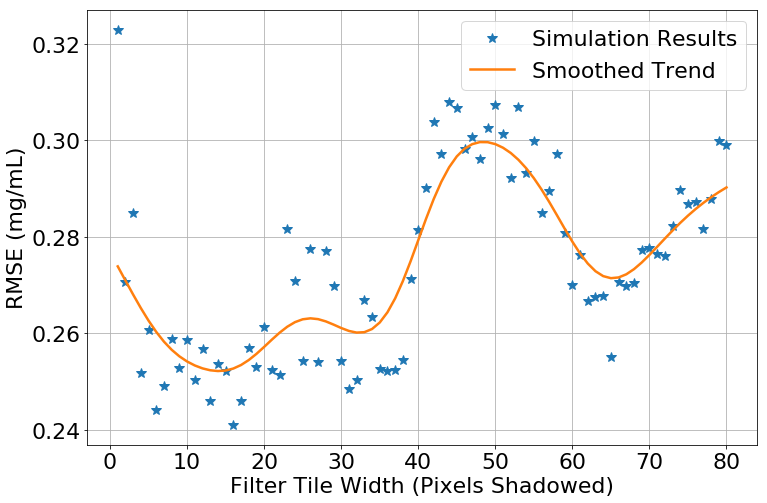

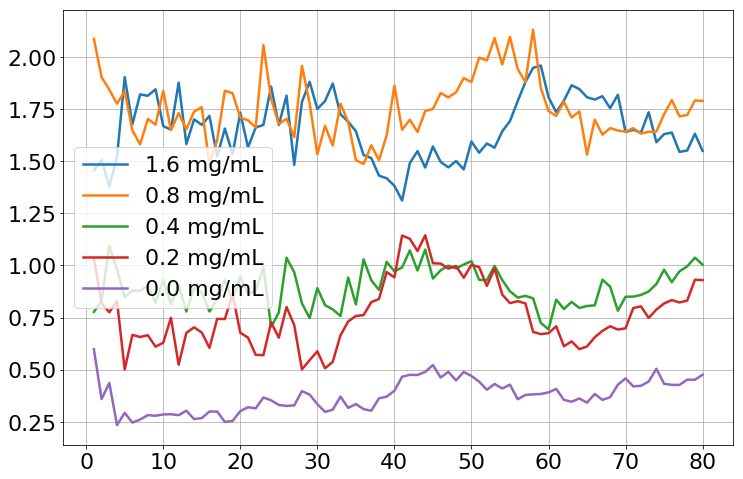

In [755]:

filter_widths = np.arange(1,81)
RMSE = np.zeros([5,filter_widths.size])

RMSEall = np.zeros(len(filter_widths))

for iFilt in np.arange(0,len(filter_widths)):
    
    data = io.loadmat('data/xi' + str(filter_widths[iFilt]) + '.mat')
    xi = data['xi'] 

    (concentration_iodine, concentration_gadolinium, concentration_gold, RMSEtmp) = RMSE_ROI(xi)
    
    RMSE[0,iFilt] += np.mean(RMSEtmp[0, concentration_iodine[0,:]     == 1.6e-6])
    RMSE[0,iFilt] += np.mean(RMSEtmp[1, concentration_gadolinium[1,:] == 1.6e-6])
    RMSE[0,iFilt] += np.mean(RMSEtmp[2, concentration_gold[2,:]       == 1.6e-6])

    RMSE[1,iFilt] += np.mean(RMSEtmp[0, concentration_iodine[0,:]     == 0.8e-6])
    RMSE[1,iFilt] += np.mean(RMSEtmp[1, concentration_gadolinium[1,:] == 0.8e-6])
    RMSE[1,iFilt] += np.mean(RMSEtmp[2, concentration_gold[2,:]       == 0.8e-6])

    RMSE[2,iFilt] += np.mean(RMSEtmp[0, concentration_iodine[0,:]     == 0.4e-6])
    RMSE[2,iFilt] += np.mean(RMSEtmp[1, concentration_gadolinium[1,:] == 0.4e-6])
    RMSE[2,iFilt] += np.mean(RMSEtmp[2, concentration_gold[2,:]       == 0.4e-6])

    RMSE[3,iFilt] += np.mean(RMSEtmp[0, concentration_iodine[0,:]     == 0.2e-6])
    RMSE[3,iFilt] += np.mean(RMSEtmp[1, concentration_gadolinium[1,:] == 0.2e-6])
    RMSE[3,iFilt] += np.mean(RMSEtmp[2, concentration_gold[2,:]       == 0.2e-6])
    
    RMSE[4,iFilt] += np.mean(RMSEtmp[0, concentration_iodine[0,:]     == 0.0e-6])
    RMSE[4,iFilt] += np.mean(RMSEtmp[1, concentration_gadolinium[1,:] == 0.0e-6])
    RMSE[4,iFilt] += np.mean(RMSEtmp[2, concentration_gold[2,:]       == 0.0e-6])
    
    RMSEall[iFilt] += np.mean(RMSEtmp)
    

    
lw = 2.5
plt.figure(figsize=(12,8))
plt.plot(filter_widths, RMSEall*1e6,'*',linewidth=lw, markersize=10)


sigma = 4
gaussian_kernel = stats.norm.pdf(np.linspace(-5*sigma, 5*sigma, 1+10*sigma),0,sigma)

RMSE_smooth = signal.convolve(RMSEall, gaussian_kernel,'same')/signal.convolve(np.ones_like(RMSEall), gaussian_kernel, 'same')

plt.plot(filter_widths,RMSE_smooth*1e6,linewidth=lw)
plt.grid()
# plt.ylim((5.4e-1, 7.6e-1))
# plt.ylim((0.0e-1, 7.6e-1))
plt.ylabel('RMSE (mg/mL)')
plt.xlabel('Filter Tile Width (Pixels Shadowed)')

plt.legend(('Simulation Results','Smoothed Trend'))


plt.savefig('figures/filterTileWidthPlot.png',format='png')






lw = 2.5
plt.figure(figsize=(12,8))

plt.plot(filter_widths, RMSE[0,:]*1e6,linewidth=lw)

sigma = 4
gaussian_kernel = stats.norm.pdf(np.linspace(-5*sigma, 5*sigma, 1+10*sigma),0,sigma)

RMSE_smooth = signal.convolve(RMSE[0,:], gaussian_kernel,'same')/signal.convolve(np.ones_like(RMSE[0,:]), gaussian_kernel, 'same')

# plt.plot(filter_widths,RMSE_smooth*1e6,linewidth=lw)



plt.plot(filter_widths, RMSE[1,:]*1e6,linewidth=lw)

sigma = 4
gaussian_kernel = stats.norm.pdf(np.linspace(-5*sigma, 5*sigma, 1+10*sigma),0,sigma)

RMSE_smooth = signal.convolve(RMSE[1,:], gaussian_kernel,'same')/signal.convolve(np.ones_like(RMSE[1,:]), gaussian_kernel, 'same')

# plt.plot(filter_widths,RMSE_smooth*1e6,linewidth=lw)


plt.plot(filter_widths, RMSE[2,:]*1e6,linewidth=lw)

sigma = 4
gaussian_kernel = stats.norm.pdf(np.linspace(-5*sigma, 5*sigma, 1+10*sigma),0,sigma)

RMSE_smooth = signal.convolve(RMSE[2,:], gaussian_kernel,'same')/signal.convolve(np.ones_like(RMSE[2,:]), gaussian_kernel, 'same')

# plt.plot(filter_widths,RMSE_smooth*1e6,linewidth=lw)



plt.plot(filter_widths, RMSE[3,:]*1e6,linewidth=lw)

sigma = 4
gaussian_kernel = stats.norm.pdf(np.linspace(-5*sigma, 5*sigma, 1+10*sigma),0,sigma)

RMSE_smooth = signal.convolve(RMSE[3,:], gaussian_kernel,'same')/signal.convolve(np.ones_like(RMSE[3,:]), gaussian_kernel, 'same')

# plt.plot(filter_widths,RMSE_smooth*1e6,linewidth=lw)



plt.plot(filter_widths, RMSE[4,:]*1e6,linewidth=lw)

sigma = 4
gaussian_kernel = stats.norm.pdf(np.linspace(-5*sigma, 5*sigma, 1+10*sigma),0,sigma)

RMSE_smooth = signal.convolve(RMSE[4,:], gaussian_kernel,'same')/signal.convolve(np.ones_like(RMSE[4,:]), gaussian_kernel, 'same')

# plt.plot(filter_widths,RMSE_smooth*1e6,linewidth=lw)




plt.legend(('1.6 mg/mL', '0.8 mg/mL', '0.4 mg/mL', '0.2 mg/mL', '0.0 mg/mL'))



plt.grid()

# plt.ylim((5.4e-1, 7.6e-1))
# # plt.ylim((0.0e-1, 7.6e-1))
# plt.ylabel('RMSE (mg/mL)')
# plt.xlabel('Filter Tile Width (Pixels Shadowed)')


# plt.savefig('figures/filterTileWidthPlot.png',format='png')


DEBUG
128
128
(4, 128, 1, 128)
(1, 1, 128)


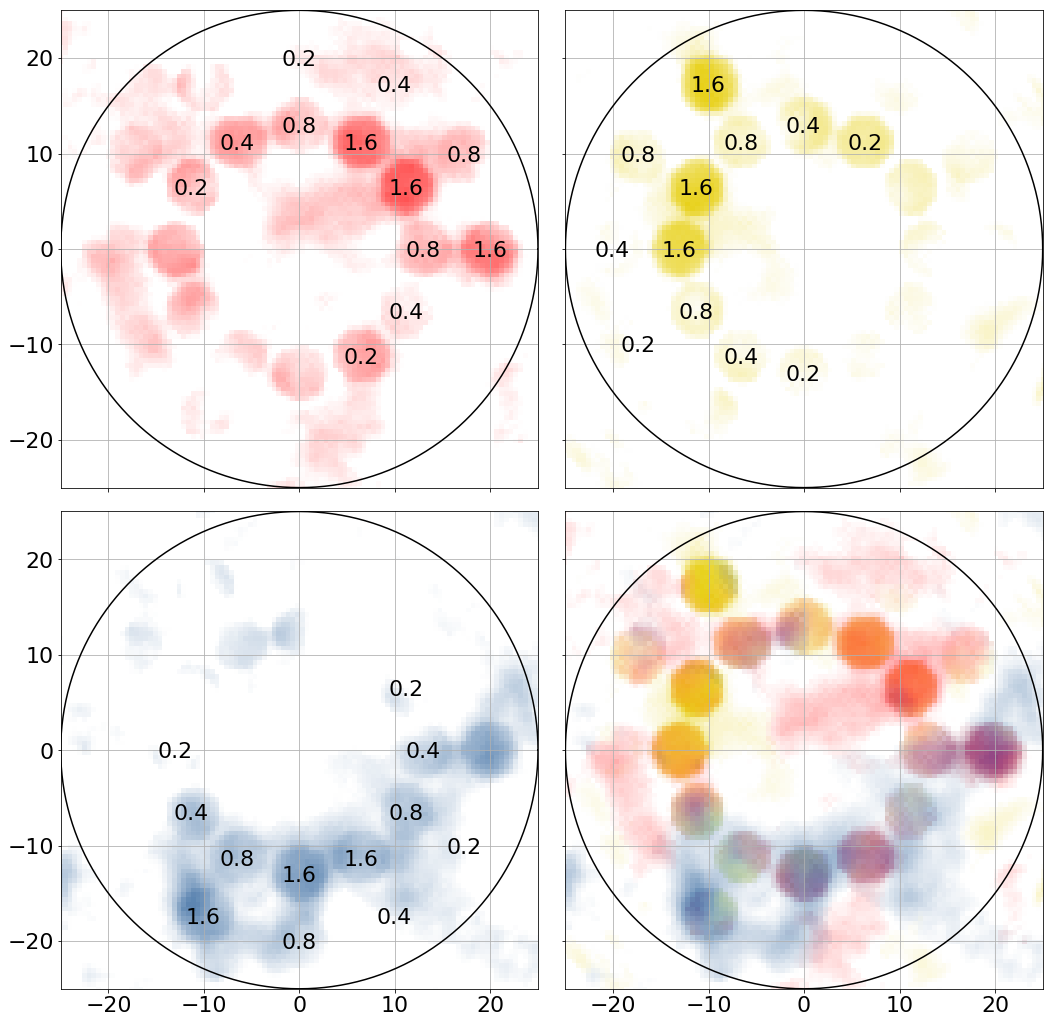

<Figure size 864x288 with 0 Axes>

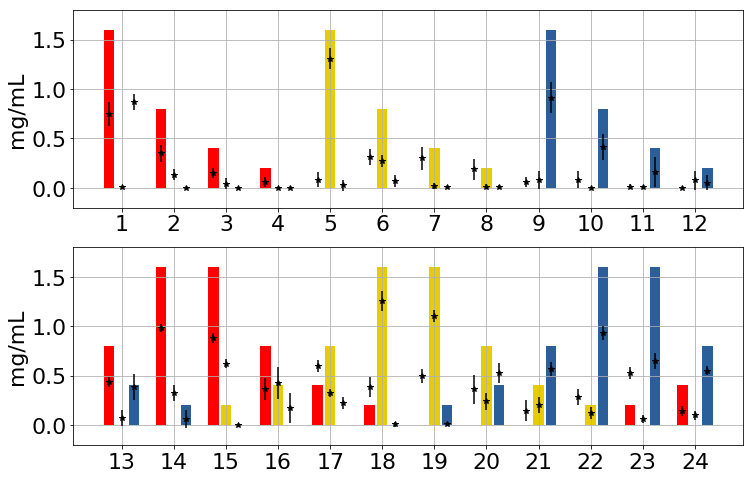

In [727]:
data = io.loadmat('data/xi3.mat')
xi = data['xi'] 

RGB_x(xi)

plt.savefig('figures/RGB_xi3.png',format='png')

bar_ROI(xi)

plt.savefig('figures/bar_xi3.png',format='png')


DEBUG
128
128
(4, 128, 1, 128)
(1, 1, 128)


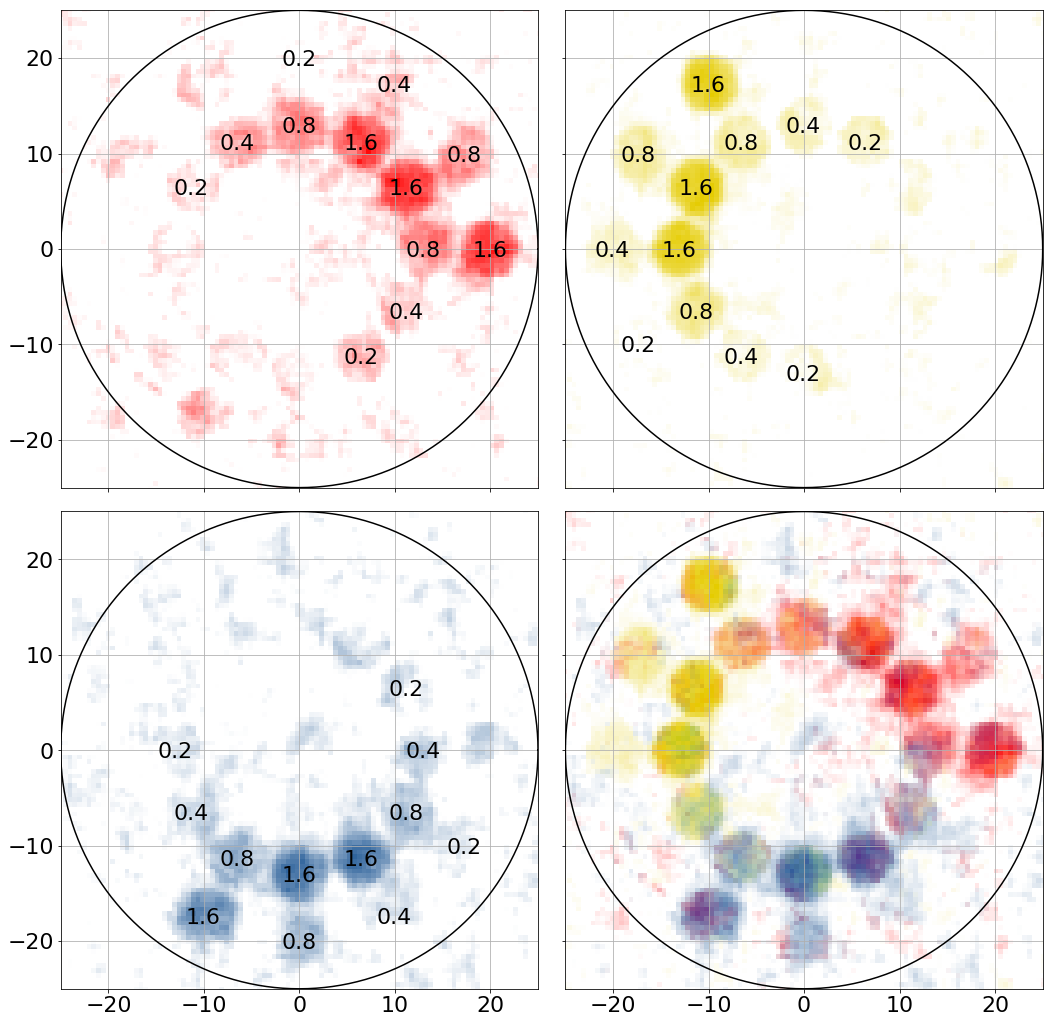

<Figure size 864x288 with 0 Axes>

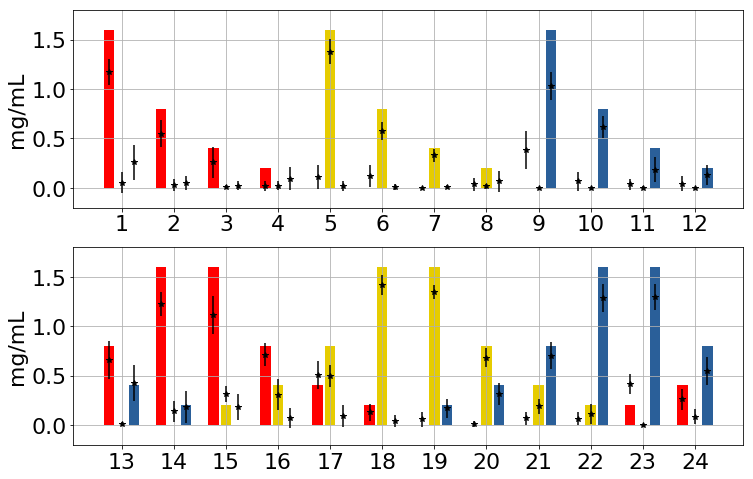

In [728]:
data = io.loadmat('data/xi8.mat')
xi = data['xi'] 
RGB_x(xi)

plt.savefig('figures/RGB_xi8.png',format='png')

bar_ROI(xi)

plt.savefig('figures/bar_xi8.png',format='png')




DEBUG
128
128
(4, 128, 1, 128)
(1, 1, 128)


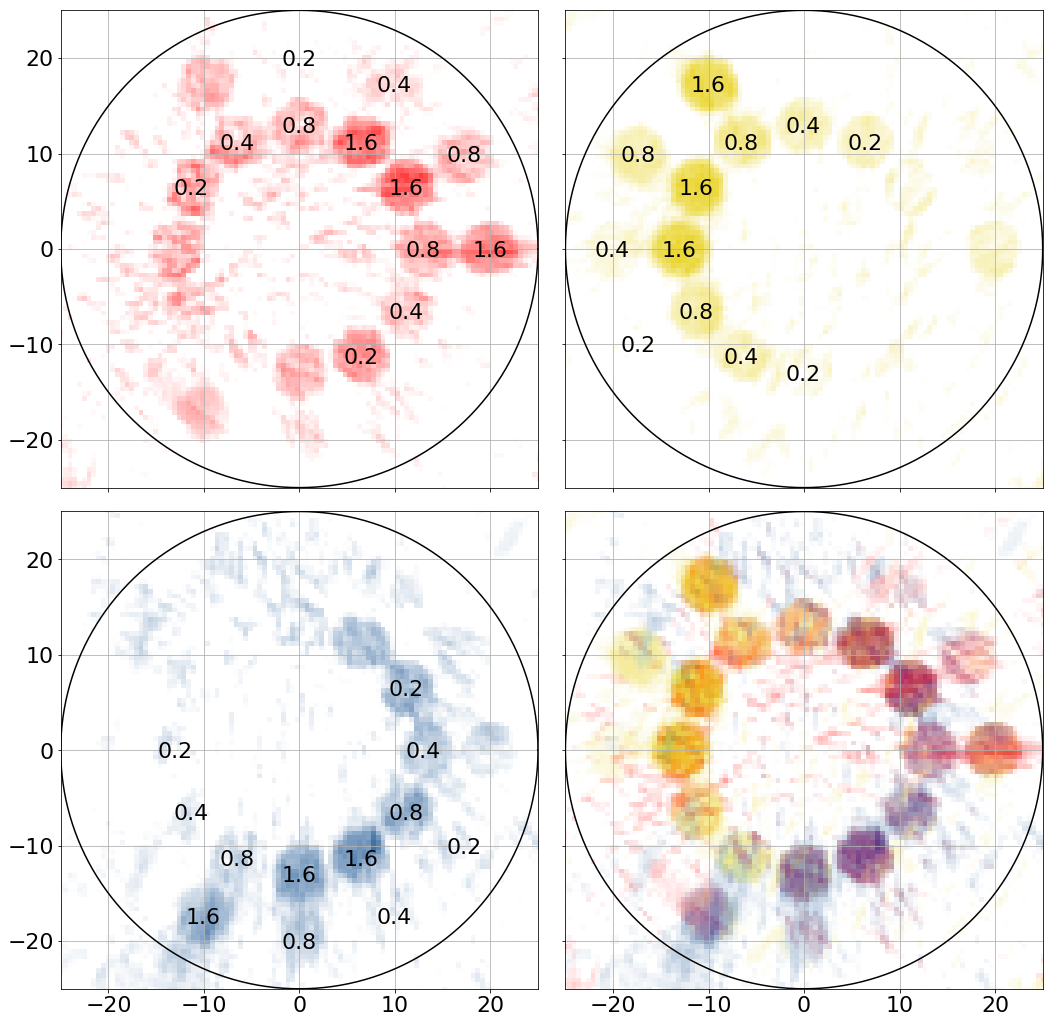

<Figure size 864x288 with 0 Axes>

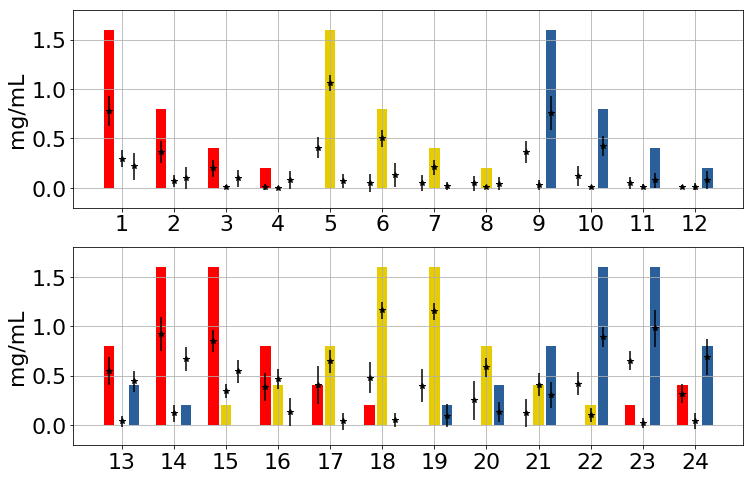

In [729]:
data = io.loadmat('data/xi50.mat')
xi = data['xi'] 

RGB_x(xi)

plt.savefig('figures/RGB_xi50.png',format='png')

bar_ROI(xi)

plt.savefig('figures/bar_xi50.png',format='png')


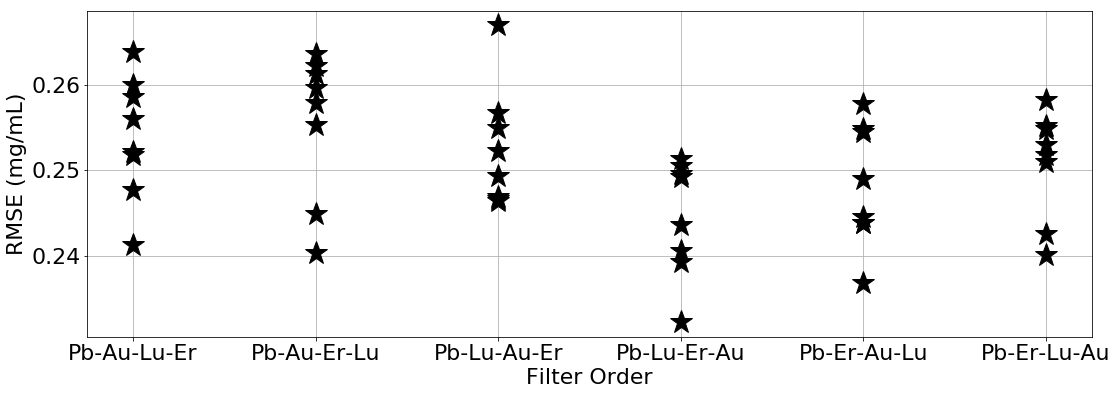

In [748]:
trialNumber = np.arange(1,9)

RMSE = np.zeros([6,8])

for iTrial in np.arange(0,len(trialNumber)):
    
    data = io.loadmat('data_order/xi1234_' + str(trialNumber[iTrial]) + '.mat')
    xi = data['xi'] 

    (concentration_iodine, concentration_gadolinium, concentration_gold, RMSEtmp) = RMSE_ROI(xi)
    RMSE[0,iTrial] += np.mean(RMSEtmp)
    

for iTrial in np.arange(0,len(trialNumber)):
    
    data = io.loadmat('data_order/xi1243_' + str(trialNumber[iTrial]) + '.mat')
    xi = data['xi'] 

    (concentration_iodine, concentration_gadolinium, concentration_gold, RMSEtmp) = RMSE_ROI(xi)
    RMSE[1,iTrial] += np.mean(RMSEtmp)    
    
for iTrial in np.arange(0,len(trialNumber)):
    
    data = io.loadmat('data_order/xi1324_' + str(trialNumber[iTrial]) + '.mat')
    xi = data['xi'] 

    (concentration_iodine, concentration_gadolinium, concentration_gold, RMSEtmp) = RMSE_ROI(xi)
    RMSE[2,iTrial] += np.mean(RMSEtmp)    
    
for iTrial in np.arange(0,len(trialNumber)):
    
    data = io.loadmat('data_order/xi1342_' + str(trialNumber[iTrial]) + '.mat')
    xi = data['xi'] 

    (concentration_iodine, concentration_gadolinium, concentration_gold, RMSEtmp) = RMSE_ROI(xi)
    RMSE[3,iTrial] += np.mean(RMSEtmp)    
    
for iTrial in np.arange(0,len(trialNumber)):
    
    data = io.loadmat('data_order/xi1423_' + str(trialNumber[iTrial]) + '.mat')
    xi = data['xi'] 

    (concentration_iodine, concentration_gadolinium, concentration_gold, RMSEtmp) = RMSE_ROI(xi)
    RMSE[4,iTrial] += np.mean(RMSEtmp)    
    
for iTrial in np.arange(0,len(trialNumber)):
    
    data = io.loadmat('data_order/xi1432_' + str(trialNumber[iTrial]) + '.mat')
    xi = data['xi'] 

    (concentration_iodine, concentration_gadolinium, concentration_gold, RMSEtmp) = RMSE_ROI(xi)
    RMSE[5,iTrial] += np.mean(RMSEtmp)    

plt.figure(figsize=(18,6))
plt.plot(np.arange(1,7), RMSE[:,0]*1e6,'*k',markersize=24)
plt.plot(np.arange(1,7), RMSE[:,1]*1e6,'*k',markersize=24)
plt.plot(np.arange(1,7), RMSE[:,2]*1e6,'*k',markersize=24)
plt.plot(np.arange(1,7), RMSE[:,3]*1e6,'*k',markersize=24)
plt.plot(np.arange(1,7), RMSE[:,4]*1e6,'*k',markersize=24)
plt.plot(np.arange(1,7), RMSE[:,5]*1e6,'*k',markersize=24)
plt.plot(np.arange(1,7), RMSE[:,6]*1e6,'*k',markersize=24)
plt.plot(np.arange(1,7), RMSE[:,7]*1e6,'*k',markersize=24)
# plt.errorbar(np.arange(1,7), np.mean(RMSE,axis=1)*1e6, yerr=np.sqrt(np.var(RMSE,axis=1)*1e6*1e6), fmt='*k',linewidth=3)

# sigma = 4
# gaussian_kernel = stats.norm.pdf(np.linspace(-5*sigma, 5*sigma, 1+10*sigma),0,sigma)


# RMSE_smooth = signal.convolve(RMSE, gaussian_kernel,'same')/signal.convolve(np.ones_like(RMSE), gaussian_kernel, 'same')

# plt.plot(filter_widths,RMSE_smooth*1e6)

plt.grid()

# plt.ylim((5.4e-1, 6.5e-1))
# plt.ylim((0.0e-1, 7.6e-1))
plt.ylabel('RMSE (mg/mL)')
plt.xlabel('Filter Order')

plt.xticks(np.arange(1,7), ['Pb-Au-Lu-Er', 'Pb-Au-Er-Lu', 'Pb-Lu-Au-Er', 'Pb-Lu-Er-Au', 'Pb-Er-Au-Lu', 'Pb-Er-Lu-Au'])
# plt.yticks(np.arange(0.55,0.65,0.03))

plt.savefig('figures/filterOrderPlot.png',format='png')

In [596]:


def RGB_x2(xi):
    
    
    nX = xi.shape[1]
    nZ = xi.shape[3]
    
    R, _, C = np.ogrid[0:nX, :1, 0:nZ]

    xgrid = C*voxelSpacing
    zgrid = R*voxelSpacing
    
    xgrid = xgrid - np.mean(xgrid)
    zgrid = zgrid - np.mean(zgrid)
    
#     xi[:, (xgrid - 0.0) ** 2.0  +  (zgrid - 0.0) ** 2.0  > 25.0 ** 2.0] = 0.0    

    xi_RGB = np.transpose(xi[1:,:,0,:],(1,2,0))

    xi_RGB = xi_RGB/50.0e-6
    
    xi_RGB[xi_RGB>1.0] = 1.0


    maskRed = np.zeros_like(xi_RGB)
    maskRed[:,:,0] = 1.0

    maskGreen = np.zeros_like(xi_RGB)
    maskGreen[:,:,1] = 1.0

    maskBlue = np.zeros_like(xi_RGB)
    maskBlue[:,:,2] = 1.0

    maskYellow   = maskRed   + maskGreen
    maskMagenta  = maskRed   + maskBlue
    maskCyan     = maskGreen + maskBlue


    xRed   = 1.0 - np.stack((xi_RGB[:,:,0], xi_RGB[:,:,0], xi_RGB[:,:,0]),2)*maskCyan
    xGreen = 1.0 - np.stack((xi_RGB[:,:,1], xi_RGB[:,:,1], xi_RGB[:,:,1]),2)*maskMagenta
    xBlue  = 1.0 - np.stack((xi_RGB[:,:,2], xi_RGB[:,:,2], xi_RGB[:,:,2]),2)*maskYellow

    xRed   = np.stack((xi_RGB[:,:,0], xi_RGB[:,:,0], xi_RGB[:,:,0]),2)*maskRed
    xGreen = np.stack((xi_RGB[:,:,1], xi_RGB[:,:,1], xi_RGB[:,:,1]),2)*maskGreen
    xBlue  = np.stack((xi_RGB[:,:,2], xi_RGB[:,:,2], xi_RGB[:,:,2]),2)*maskBlue

    
    font = {'color':  'black',
        }


    
    theta1 = np.arange(0.0, 2.0*np.pi, 2.0*np.pi/12.0)

    xcenter1 = 20.0*np.cos(theta1)
    zcenter1 = 20.0*np.sin(theta1)

    concentration_iodine1     = [ 1.6e-6,   0.8e-6,  0.4e-6, 0.2e-6,  0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0    ]
    concentration_gadolinium1 = [ 0.0,      0.0,     0.0,    0.0,     1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6,  0.0,     0.0,     0.0,     0.0    ]
    concentration_gold1       = [ 0.0,      0.0,     0.0,    0.0,     0.0,     0.0,     0.0,     0.0,     1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6 ]

    
    theta2 = np.arange(0.0, 2.0*np.pi, 2.0*np.pi/12.0)

    xcenter2 = 13.0*np.cos(theta2)
    zcenter2 = 13.0*np.sin(theta2)

    concentration_iodine2     = [ 0.8e-6,  1.6e-6,  1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6,  0.0,     0.0,     0.0,     0.0,     0.2e-6,  0.4e-6  ]
    concentration_gadolinium2 = [ 0.0,     0.0,     0.2e-6,  0.4e-6,  0.8e-6,  1.6e-6,  1.6e-6,  0.8e-6,  0.4e-6,  0.2e-6,  0.0,     0.0     ]
    concentration_gold2       = [ 0.4e-6,  0.2e-6,  0.0,     0.0,     0.0,     0.0,     0.2e-6,  0.4e-6,  0.8e-6,  1.6e-6,  1.6e-6,  0.8e-6  ]


    ext = (np.min(xgrid), np.max(xgrid), np.max(zgrid), np.min(zgrid))
    
    

    plt.rcParams.update({'font.size': 22})

    # f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(18,18))
    # f.suptitle('Sharing x per column, y per row', fontsize=24)


    fig = plt.figure(figsize=(18,18))
    ax = [fig.add_subplot(2,2,i+1) for i in range(4)]

    
    xRed = RYB_2_RGB_img(xRed)
    xGreen = RYB_2_RGB_img(xGreen)
    xBlue = RYB_2_RGB_img(xBlue)
    xi_RGB = RYB_2_RGB_img(xi_RGB)
    
    
    xshift = -1.9
    zshift = -0.8
    
    for a in ax:
        a.set_aspect('equal')
        a.grid()

    ax[0].imshow(xRed,extent=ext)
    ax[0].set_xticklabels([])
#     for iTheta in np.arange(0,len(theta1)):
#         if(concentration_iodine1[iTheta] > 0.0):
#             st = str(0.1*np.round(10*1e6*concentration_iodine1[iTheta]))
#             ax[0].text(xshift + xcenter1[iTheta],zshift + zcenter1[iTheta],st, fontdict=font)
#     for iTheta in np.arange(0,len(theta2)):
#         if(concentration_iodine2[iTheta] > 0.0):
#             st = str(0.1*np.round(10*1e6*concentration_iodine2[iTheta]))
#             ax[0].text(xshift + xcenter2[iTheta],zshift + zcenter2[iTheta],st, fontdict=font)


    ax[1].imshow(xGreen,extent=ext)
    ax[1].set_xticklabels([])
    ax[1].set_yticklabels([])
#     for iTheta in np.arange(0,len(theta1)):
#         if(concentration_gadolinium1[iTheta] > 0.0):
#             st = str(0.1*np.round(10*1e6*concentration_gadolinium1[iTheta]))
#             ax[1].text(xshift + xcenter1[iTheta],zshift + zcenter1[iTheta],st, fontdict=font)
#     for iTheta in np.arange(0,len(theta2)):
#         if(concentration_gadolinium2[iTheta] > 0.0):
#             st = str(0.1*np.round(10*1e6*concentration_gadolinium2[iTheta]))
#             ax[1].text(xshift + xcenter2[iTheta],zshift + zcenter2[iTheta],st, fontdict=font)

            
    ax[2].imshow(xBlue,extent=ext)
#     for iTheta in np.arange(0,len(theta1)):
#         if(concentration_gold1[iTheta] > 0.0):
#             st = str(0.1*np.round(10*1e6*concentration_gold1[iTheta]))
#             ax[2].text(xshift + xcenter1[iTheta],zshift + zcenter1[iTheta],st, fontdict=font)
#     for iTheta in np.arange(0,len(theta2)):
#         if(concentration_gold2[iTheta] > 0.0):
#             st = str(0.1*np.round(10*1e6*concentration_gold2[iTheta]))
#             ax[2].text(xshift + xcenter2[iTheta],zshift + zcenter2[iTheta],st, fontdict=font)

    ax[3].imshow(xi_RGB,extent=ext)
    ax[3].set_yticklabels([])
    
    for a in ax:
        a.set_xlim(-40,40)
        a.set_ylim(-40,40)

    plt.subplots_adjust(wspace=0.01, hspace=0.05)



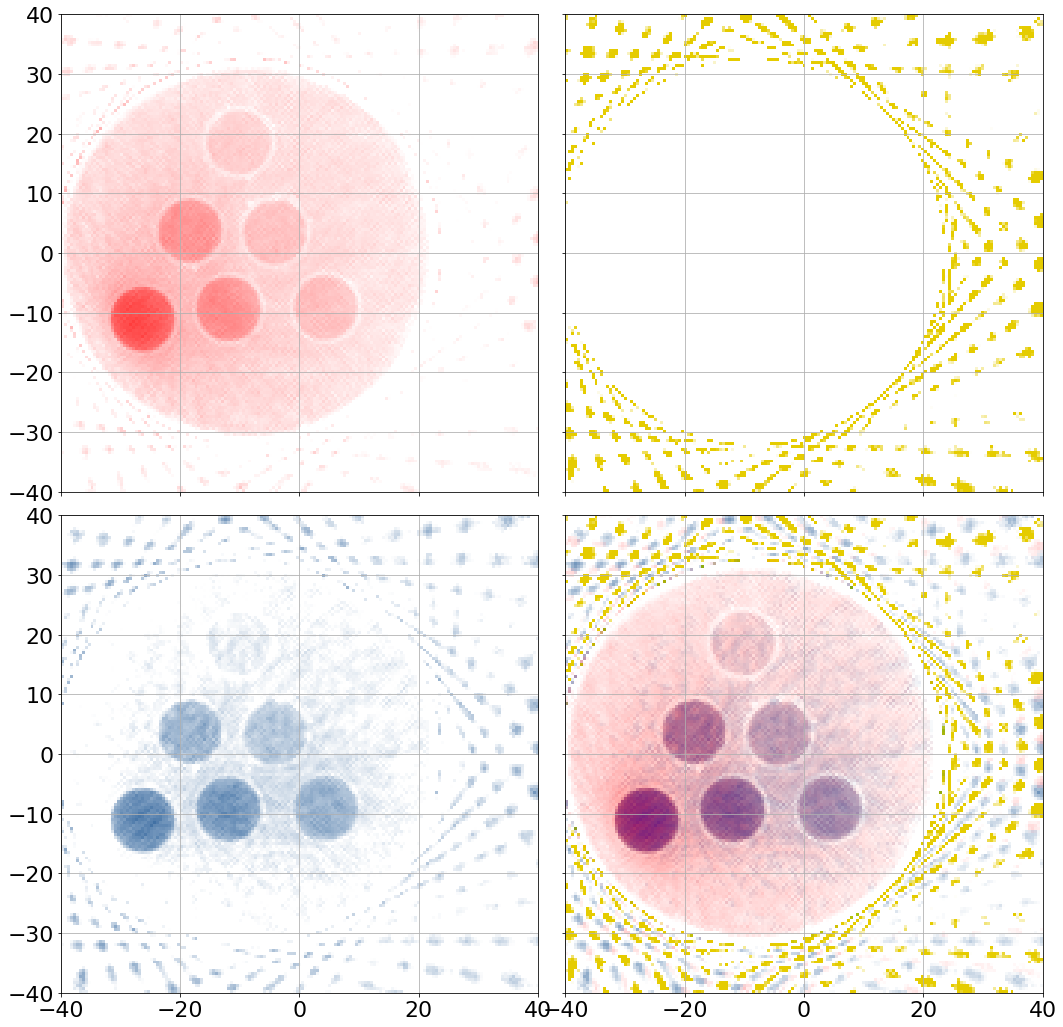

In [617]:
data = io.loadmat('../Phantom_Iodine_Gadolinium_Gold_6Vials/data/xi_8.mat')
xi = data['xi'] 
    
    
# plt.imshow(np.squeeze(xi[2,:,:,:]))


xi[1,:,:,:] = xi[1,:,:,:]*400.0e-6/150.0e-6
xi[2,:,:,:] = xi[2,:,:,:]*300.0e-6/5.0e-6
xi[3,:,:,:] = xi[3,:,:,:]*20.0e-6/5.0e-6



RGB_x2(xi)

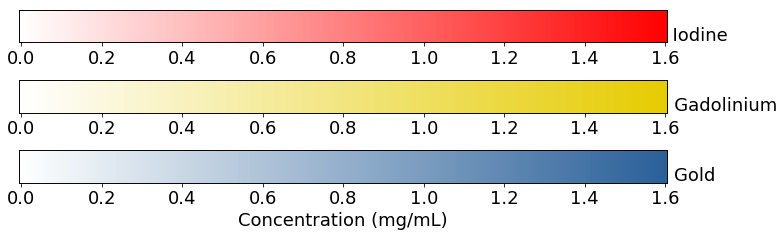

In [875]:
xred = np.zeros([1,160,3])
xred[0,:,0] = np.arange(0,160)/160

xgreen = np.zeros([1,160,3])
xgreen[0,:,1] = np.arange(0,160)/160

xblue = np.zeros([1,160,3])
xblue[0,:,2] = np.arange(0,160)/160

xRed = RYB_2_RGB_img(xred)
xYellow = RYB_2_RGB_img(xgreen)
xBlue = RYB_2_RGB_img(xblue)


fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
ax2 = fig.add_axes([0.05, 0.475, 0.9, 0.15])
ax3 = fig.add_axes([0.05, 0.15, 0.9, 0.15])


ax1.imshow(xRed)
ax1.axis('tight')
ax1.set_yticks([])
ax1.yaxis.tick_right()
ax1.set_xticks([])
axtmp = ax1.twinx()
h = axtmp.set_ylabel('          Iodine')
h.set_rotation(0)
axtmp.set_yticks([])
# ax1.set_yticks([])
ax1.set_xticks(np.arange(0,161,20)*159/160)
ax1.set_xticklabels(np.arange(0,161,20)/100)

ax2.imshow(xYellow)
ax2.axis('tight')
ax2.set_yticks([])
ax2.yaxis.tick_right()
ax2.set_xticks([])
axtmp = ax2.twinx()
h = axtmp.set_ylabel('                   Gadolinium')
h.set_rotation(0)
axtmp.set_yticks([])
# ax1.set_yticks([])
ax2.set_xticks(np.arange(0,161,20)*159/160)
ax2.set_xticklabels(np.arange(0,161,20)/100)

ax3.imshow(xBlue)
ax3.axis('tight')
ax3.set_yticks([])
ax3.yaxis.tick_right()
axtmp = ax3.twinx()
h = axtmp.set_ylabel('        Gold')
h.set_rotation(0)
axtmp.set_yticks([])
# ax1.set_yticks([])
ax3.set_xticks(np.arange(0,161,20)*159/160)
ax3.set_xticklabels(np.arange(0,161,20)/100)
ax3.set_xlabel('Concentration (mg/mL)')

plt.savefig('figures/RYB_colorbar.png',format='png')

